I have been working with [multi-armed bandit algorithms](https://en.wikipedia.org/wiki/Multi-armed_bandit) in the course of my [day job](https://monetate.com/) for almost a decade now.  Through this experience, I have been surprised many times by the tradeoffs that arise in these systems, and plan to discuss a few of them in a series of posts.  This post will explore the relationship between the [exploration-exploitation tradeoff](https://en.wikipedia.org/wiki/Exploration-exploitation_dilemma#Multi-armed_bandit_methods) and [statistical bias](https://en.wikipedia.org/wiki/Bias_(statistics)) in multi-armed bandits.

## A crash course in multi-armed bandits

As this is the first post in the series, we being with an introduction to the multi-armed bandit problem.

![An octopus playing row of slot machines simultaneously](https://blogs.mathworks.com/images/loren/2016/multiarmedbandit.jpg)

The archetypal description of the multi-armed bandit problem (from which it takes its name) is walking into a casino and being presented with a row of slot machines.  You must decide which slot machine to play in order to maximize your winnings (or, realistically, to minimize your losses).  The casino, however, does not post the payout rates of each machine.  You must play each enough to estimate its payout rate and gain confidence in which is the best long-term choice.  This need to take some actions that we know will be suboptimal in order to determine the optimal action is the exploration-exploitation tradeoff that multi-armed bandit algorithms attempt to address.

There are many [variations](https://en.wikipedia.org/wiki/Multi-armed_bandit#Variations) on the multi-armed bandit problem laid out above, but for this post we focus on the following simple formulation.  Assume there are $m$ actions, $a_1, a_2, \ldots, a_m$ that we can take at any point in time $t$.  Let $n_{i, t}$ be the number of times the $i$-th action has been played up to and including time $t$, and let $x_{i, t}$ be the total rewards received from playing the $i$-th action up to and including time $t$.  Let $\mathbf{n}_t = (n_{1, t}, n_{2, t}, \ldots, n_{m, t})$ and $\mathbf{x}_t = (x_{1, t}, x_{2, t}, \ldots, x_{m, t})$.  A policy, $f$, is a function that chooses the next action to play given the history of past actions and rewards,

$$f(t, \mathbf{n}_{t - 1}, \mathbf{x}_{t - 1}) \in \{a_1, a_2, \ldots, a_m\}.$$

### Simulating policy performance

While many approaches to the multi-armed bandit problem are amenable to theoretical analysis, the mathematics involved are can be complex and present a barrier to understanding (I say this lovingly, as a former mathematician), so in this post we will examine the properties of various policies through simulation.  For simplicity in this simulation, we will consider two arms with [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) binary rewards, $r_i \sim \mathrm{Ber}(p_i)$.  We fix the first arm's reward rate at 50% and the second at 60%.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from decorator import decorator
from fastprogress.fastprogress import progress_bar

In [3]:
from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

In [4]:
sns.set(color_codes=True)

pct_formatter = ticker.StrMethodFormatter("{x:.1%}")

In [5]:
ARM_RATES = np.array([0.5, 0.6])

ARM_LABELS = [f"Arm {i} ({rate:.1%})" for i, rate in enumerate(ARM_RATES)]

We will evaluate each policy across 2,000 time steps.

In [6]:
T = 2_000

To truly study the statistical properties of a policy one simulation is insufficient, so we will simulate the performance of each policy 3,001 times.

In [7]:
N_SIM = 3_001

We now generate our simulated rewards.

In [8]:
SEED = 1234567890

rng = np.random.default_rng(SEED)

In [9]:
reward = rng.binomial(1, ARM_RATES[:, np.newaxis], size=(N_SIM, 2, T))

Throughout this post, arrays related to our simulation will usually have their first axis correspond to a single simulation, their second axis correspond to an arm, and their third axis correspond to time.

We see that our simulations are reasonable because the empirical arm reward rates (averaging over all simulations and times) are quite close to the true rates of 50% and 60%.

In [10]:
ARM_RATES - reward.mean(axis=(0, 2))

array([0.00024442, 0.00018477])

With the above framework set, we are ready to start simulating the performance of various policies.  Recall that, mathematically, a policy is a function

$$f(t, \mathbf{n}_{t - 1}, \mathbf{x}_{t - 1}) \in \{a_1, a_2, \ldots, a_m\}.$$

The signature of such a mathematical policy function is shown below in Python.

In [11]:
def policy(
    t,              # how many steps have in the simulation have
                    # already occurred
    arm_ct,         # how many times each arm has been shown in past,
                    # shape is (N_SIM, N_ARM)
    arm_reward_ct,  # how many times each arm has been shown and a
                    # reward recieved in the past, shape is (N_SIM, N_ARM),
    rng=None,       # random number generator, for reproducibility
    **kwargs        # some policies will take other parameters
):
    # returns the index of the arm selected for the next step,
    # shape is (N_SIM, 1)
    raise NotImplementedError

Given such a policy, the following function simulates its performance given simulated reward data.

In [12]:
def simulate_policy(policy, reward, progress=False, **policy_kwargs):
    *_, T = reward.shape

    # record of when each arm was chosen
    arm = np.full_like(reward, False, dtype=np.bool_)
    
    # record of how often each arm has been chosen prior to the current step
    arm_ct = np.zeros_like(reward[..., 0], dtype=np.int64)
    
    # record of how often each arm has been chosen and generate a reward
    # prior to the current step
    arm_reward_ct = np.zeros_like(reward[..., 0], dtype=np.int64)
    
    steps = range(T)
    
    if progress:
        steps = progress_bar(steps)

    for t in steps:
        # get the next arm chosen by the policy
        next_arm = policy(t, arm_ct, arm_reward_ct, **policy_kwargs)

        # update our records of arms and rewards
        np.put_along_axis(arm[..., t], next_arm, True, axis=1)
        arm_ct += arm[..., t]
        arm_reward_ct += reward[..., t] * arm[..., t]
    
    return np.ma.masked_array(reward, mask=~arm)

### A simple, illustrative policy

The following simple policy that always chooses the first arm illustrates the output of this function and the various quantities we will be interested in when studying policy performance.

In [13]:
def first(_, arm_ct, *__, **___):
    return np.zeros_like(arm_ct)

In [14]:
first_reward = simulate_policy(first, reward, progress=True)

We see that `first_reward` has the same shape as `reward`, and its axes have the same meaning.

In [15]:
first_reward.shape

(3001, 2, 2000)

Examining a the first five time steps of the first simulation in `first_reward`, we see that it is a [masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html), indicating which rewards from `reward` where actually observed by the policy.

In [16]:
first_reward[0, :, :5]

masked_array(
  data=[[1, 0, 1, 1, 1],
        [--, --, --, --, --]],
  mask=[[False, False, False, False, False],
        [ True,  True,  True,  True,  True]],
  fill_value=999999)

Here all the entries corresponding to the first arm are unmasked and all those corresponding to the second are masked, because our simple policy always chooses the first arm.  We will soon see the result of more complex policies.

### A/B test (randomized control trial)

Another simple policy that will nevertheless be instructive to analyze is what is known in digitial marketing as [A/B testing](https://en.wikipedia.org/wiki/A/B_testing) and in more scientific circles as a [randomized control trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial) (RCT).  Since I work at a digital marketing SaaS company I will use the term "A/B testing" for convenience.

At each step, this policy chooses each arm with a fixed probability (50% for simplicity in this example), regardless of past performance.

In [17]:
def ab_test(_, arm_ct, *__, rng=None, **___):
    if rng is None:
        rng = np.random.default_rng()

    n_sim, n_arm = arm_ct.shape

    return rng.choice(n_arm, size=(n_sim, 1))

We now simulate the performance of this policy.

In [18]:
ab_test_reward = simulate_policy(ab_test, reward, progress=True, rng=rng)

We see that, unlike with the previous policy, there are unmasked entries for both arms.

In [19]:
ab_test_reward[0, :, :5]

masked_array(
  data=[[1, 0, 1, --, 1],
        [--, --, --, 1, --]],
  mask=[[False, False, False,  True, False],
        [ True,  True,  True, False,  True]],
  fill_value=999999)

The following functions calculate the number of times and percentage of the time each arm has been chosen as the simulation advances using the mask on `ab_test_reward`.

In [20]:
def get_time(reward):
    *_, t_max = reward.shape

    return 1 + np.arange(t_max)

In [21]:
def cum_arm_ct(reward):
    return np.logical_not(reward.mask).cumsum(axis=-1)

def cum_arm_pct(reward):
    return cum_arm_ct(reward) / get_time(reward)

As expected, we see that each arm is chosen about 50% of the time. 

In [22]:
def make_pct_axis(ax, *, label=None, full=True, which="y"):
    if full:
        getattr(ax, f"set_{which}lim")(0, 1)
        getattr(ax, f"set_{which}ticks")(np.linspace(0, 1, 5))
    
    getattr(ax, f"{which}axis").set_major_formatter(pct_formatter)
    
    if label is not None:
        getattr(ax, f"set_{which}label")(label)

def make_time_axis(ax, t_max=T):
    ax.set_xlim(0, t_max)
    ax.set_xlabel("Time")

In [23]:
def plot_arm_allocation(reward, label=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(cum_arm_pct(reward).mean(axis=0).T, label=label)

    make_time_axis(ax)
    make_pct_axis(ax, label="Arm allocation")
    
    return ax

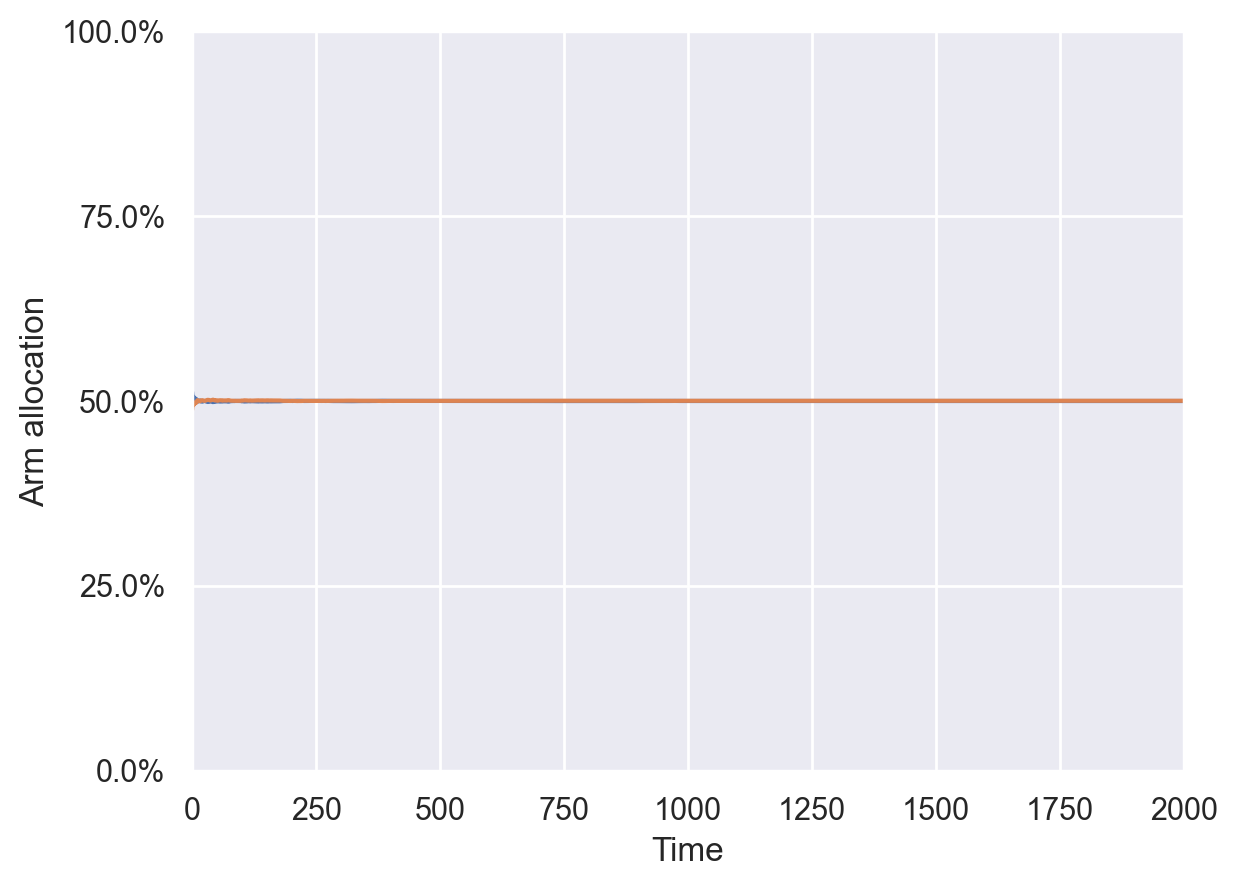

In [24]:
plot_arm_allocation(ab_test_reward);

As stated in the introduction, the fundamental of the multi-armed bandit algorithms is to maximize the reward realized.  In the research literature on mulit-armed bandits, this is typically rephrased as minimizing the [regret](https://en.wikipedia.org/wiki/Regret_(decision_theory)), which is the difference between the theoretical maximum reward possible (if reward rates were known a priori) and the realized reward.  The following functions compute the regret for our simulation results.

In [25]:
def cum_reward(reward):
    return reward.filled(0).cumsum(axis=-1)

def cum_regret(reward, arm_rates=ARM_RATES):
    return arm_rates.max() * get_time(reward) - cum_reward(reward)

The regret for our A/B testing policy is shown below.

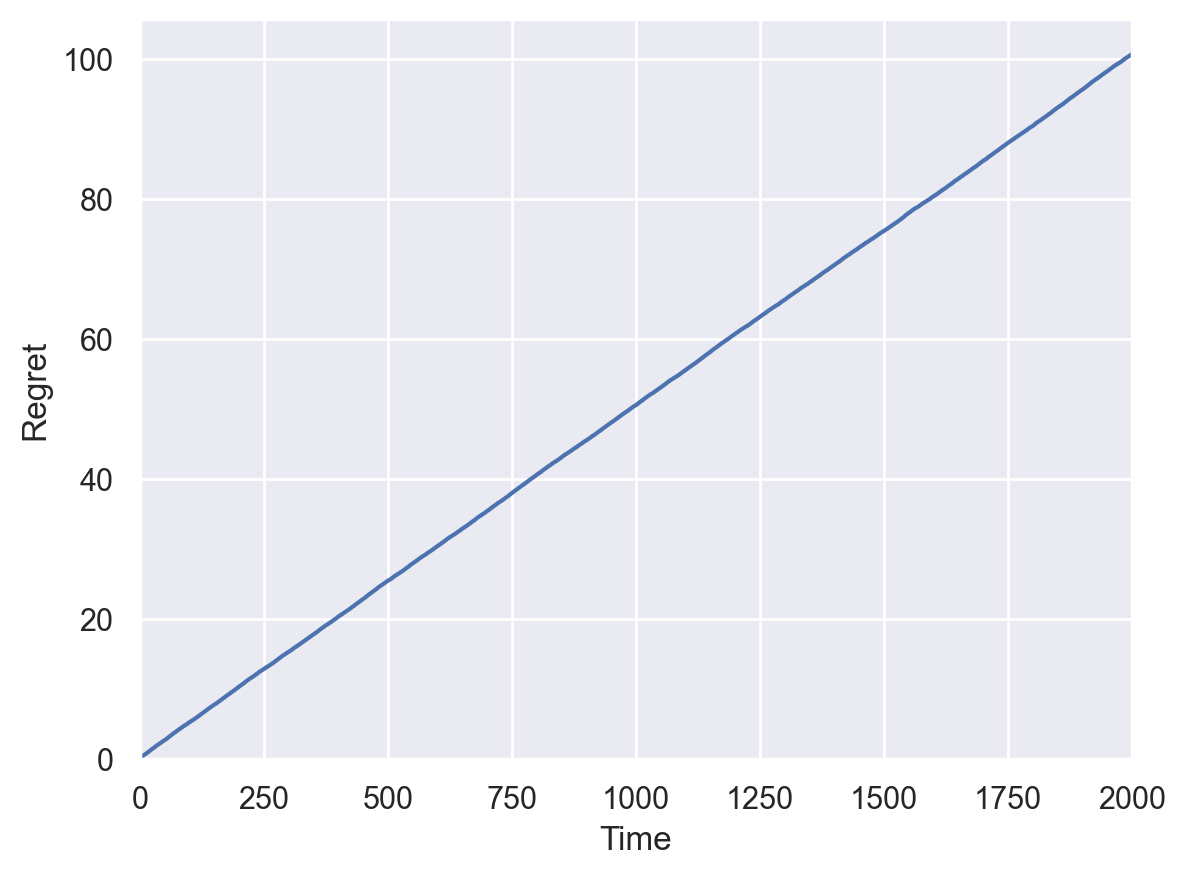

In [26]:
fig, ax = plt.subplots()

ax.plot(cum_regret(ab_test_reward.sum(axis=1)).mean(axis=0));

make_time_axis(ax)

ax.set_ylim(bottom=0);
ax.set_ylabel("Regret");

The simplicity of the A/B testing polic allows us to confirm this result theoretically.  Since it chooses each arm with a 50% probability, its reward rate should be the average of the arm reward rates.  We do in fact see that these quantities are quite close.

In [27]:
ab_test_reward.mean() - ARM_RATES.mean()

-0.0003065644785071875

That means that the regret should increase at the rate of

In [28]:
ARM_RATES.max() - ARM_RATES.mean()

0.04999999999999993

per unit of time.  We see that this theory does agree with our simulations, which is a good sanity check on our code.

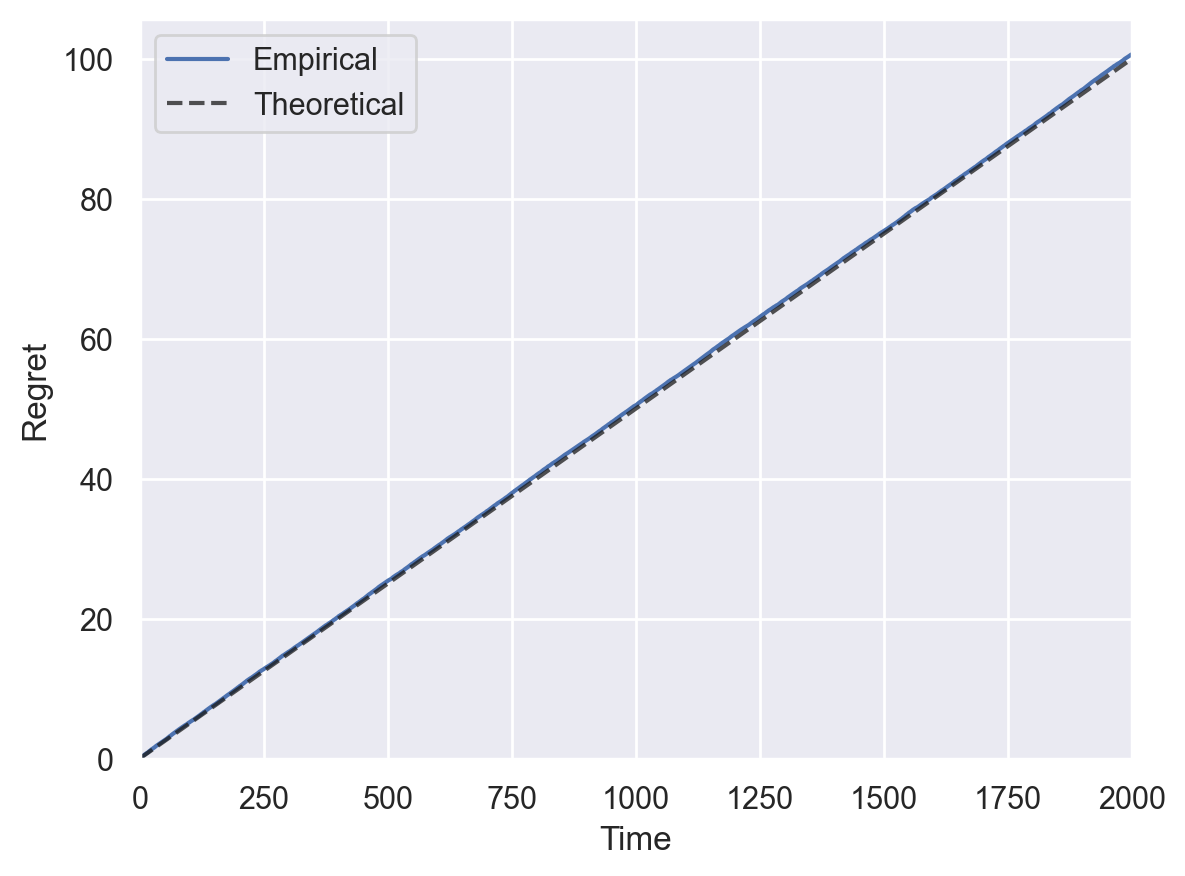

In [29]:
fig, ax = plt.subplots()

ax.plot(cum_regret(ab_test_reward.sum(axis=1)).mean(axis=0),
        label="Empirical");

ax.axline((0, 0), slope=ARM_RATES.max() - ARM_RATES.mean(),
          c="k", ls="--", alpha=0.75,
          label="Theoretical");

make_time_axis(ax)

ax.set_ylim(bottom=0);
ax.set_ylabel("Regret");

ax.legend();

While the multi-armed bandit problem is typically phrased in terms of absolute regret, it will be useful in this post to use the equivalent lens of regret rate, which is just the regret divided by the amount of time passed.

In [30]:
def cum_reward_rate(reward):
    return cum_reward(reward) / get_time(reward)
    
def cum_regret_rate(reward, arm_rates=ARM_RATES):
    return arm_rates.max() - cum_reward_rate(reward)

In [31]:
def plot_cum_regret_rate(reward, label=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(cum_regret_rate(reward.sum(axis=1)).mean(axis=0), label=label)

    make_time_axis(ax)
    
    make_pct_axis(ax, label="Regret rate", full=False)
    ax.set_ylim(bottom=0)
    
    return ax

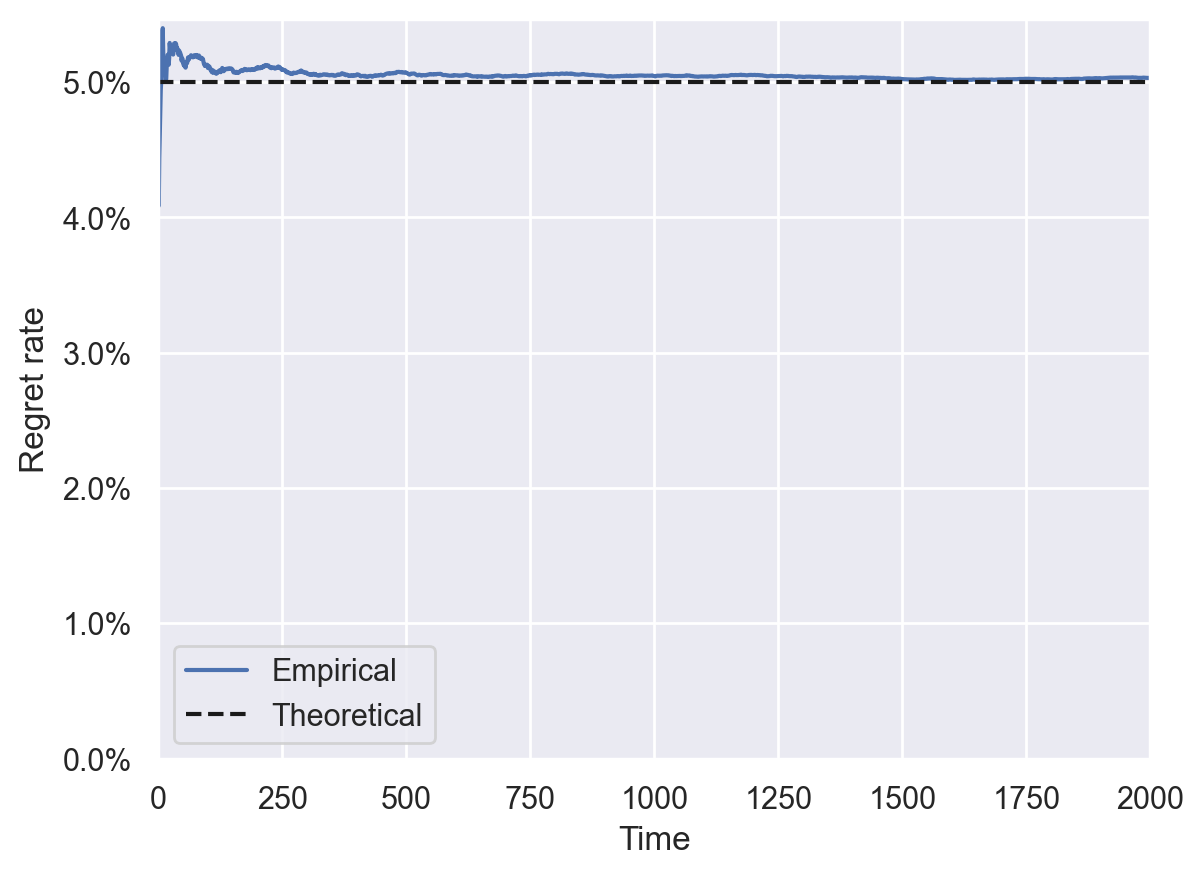

In [32]:
ax = plot_cum_regret_rate(ab_test_reward, label="Empirical")

ax.axhline(ARM_RATES.ptp() / 2, c="k", ls="--", label="Theoretical")

ax.legend();

The bias-variance tradeoff will become apparent when we consider one more set of statistics related to the mulit-armed bandit's performance.  These are the empirical estimators of the **per-arm** reward rates.  These statistics are especially important in my line of work, where we are providing access to such algorithms to nontechnical marketers who are accustomed to detailed performance reports on all of their [campaigns](https://en.wikipedia.org/wiki/Advertising_campaign).  The following functions calculate these empirical estimators,

$$\hat{r}_{i, t} = \frac{x_{i, t}}{n_{i, t}}.$$

In [33]:
def cum_arm_reward_rate(reward):
    return cum_reward(reward) / np.maximum(1, cum_arm_ct(reward))

The following plot shows that the empirical reward rate for samples generated by A/B testing are [unbiased](https://en.wikipedia.org/wiki/Bias_(statistics)) estimators of the actual arm reward rates. Here we are using the word _unbiased_ in the [statistical sense](https://en.wikipedia.org/wiki/Bias_(statistics)): an estimator is unbiased if its expected value is the true value of the parameter in question.

In [34]:
CI_WIDTH = 0.95

In [35]:
def plot_cum_arm_reward_rate(reward, ci_width=CI_WIDTH, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    cum_arm_reward_rate_ = cum_arm_reward_rate(reward)

    ax.plot(cum_arm_reward_rate_[:, 0].mean(axis=0),
            alpha=0.9, label="Empirical mean");
    ax.plot(cum_arm_reward_rate_[:, 1].mean(axis=0),
            alpha=0.9);
    
    if ci_width is not None:
        alpha = 1 - ci_width
        q = [100 * alpha / 2, 100 * (1 - alpha / 2)]
        t = get_time(reward)

        ax.fill_between(
            t, *np.percentile(cum_arm_reward_rate_[:, 0], q, axis=0),
            alpha=0.5, color="C0", label="95% CI"
        )
        ax.fill_between(
            t, *np.percentile(cum_arm_reward_rate_[:, 1], [2.5, 97.5], axis=0),
            alpha=0.5, color="C1"
        )

    ax.axhline(ARM_RATES[0], c="C0", ls="--", label="Actual");
    ax.axhline(ARM_RATES[1], c="C1", ls="--");

    make_time_axis(ax)

    make_pct_axis(ax, full=False)
    ax.set_ylim(0.9 * ARM_RATES.min(), 1.1 * ARM_RATES.max());
    ax.set_ylabel("Reward rate");

    ax.legend()
    
    return ax

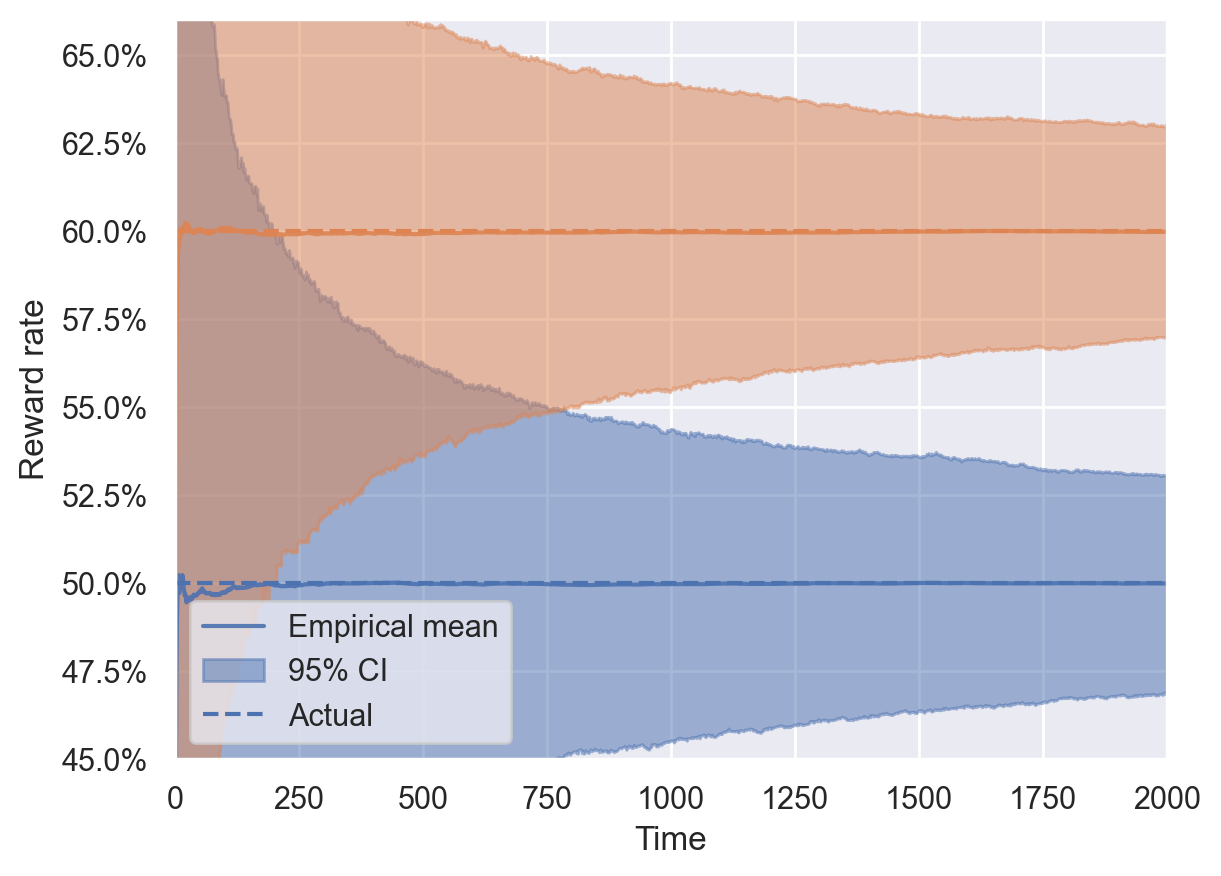

In [36]:
plot_cum_arm_reward_rate(ab_test_reward);

A/B testing produces unbiased estimators of the true arm reward rates because it does not use information about past performance to decide on the next action to take.

The bias-variance tradeoff appears in multi-armed bandits when we start to reduce regret by incorporating past rewards into future decisions.  The rest of this post will explore the implications of this seemingly simple, reasonable, and quite often desireable choice.

In [37]:
def plot_policy(reward):
    fig, axes = plt.subplots(figsize=(15, 4), ncols=3, sharex=True)
    
    plot_arm_allocation(reward, ax=axes[0])
    plot_cum_regret_rate(reward, ax=axes[1])
    plot_cum_arm_reward_rate(reward, ax=axes[2])
    
    return fig

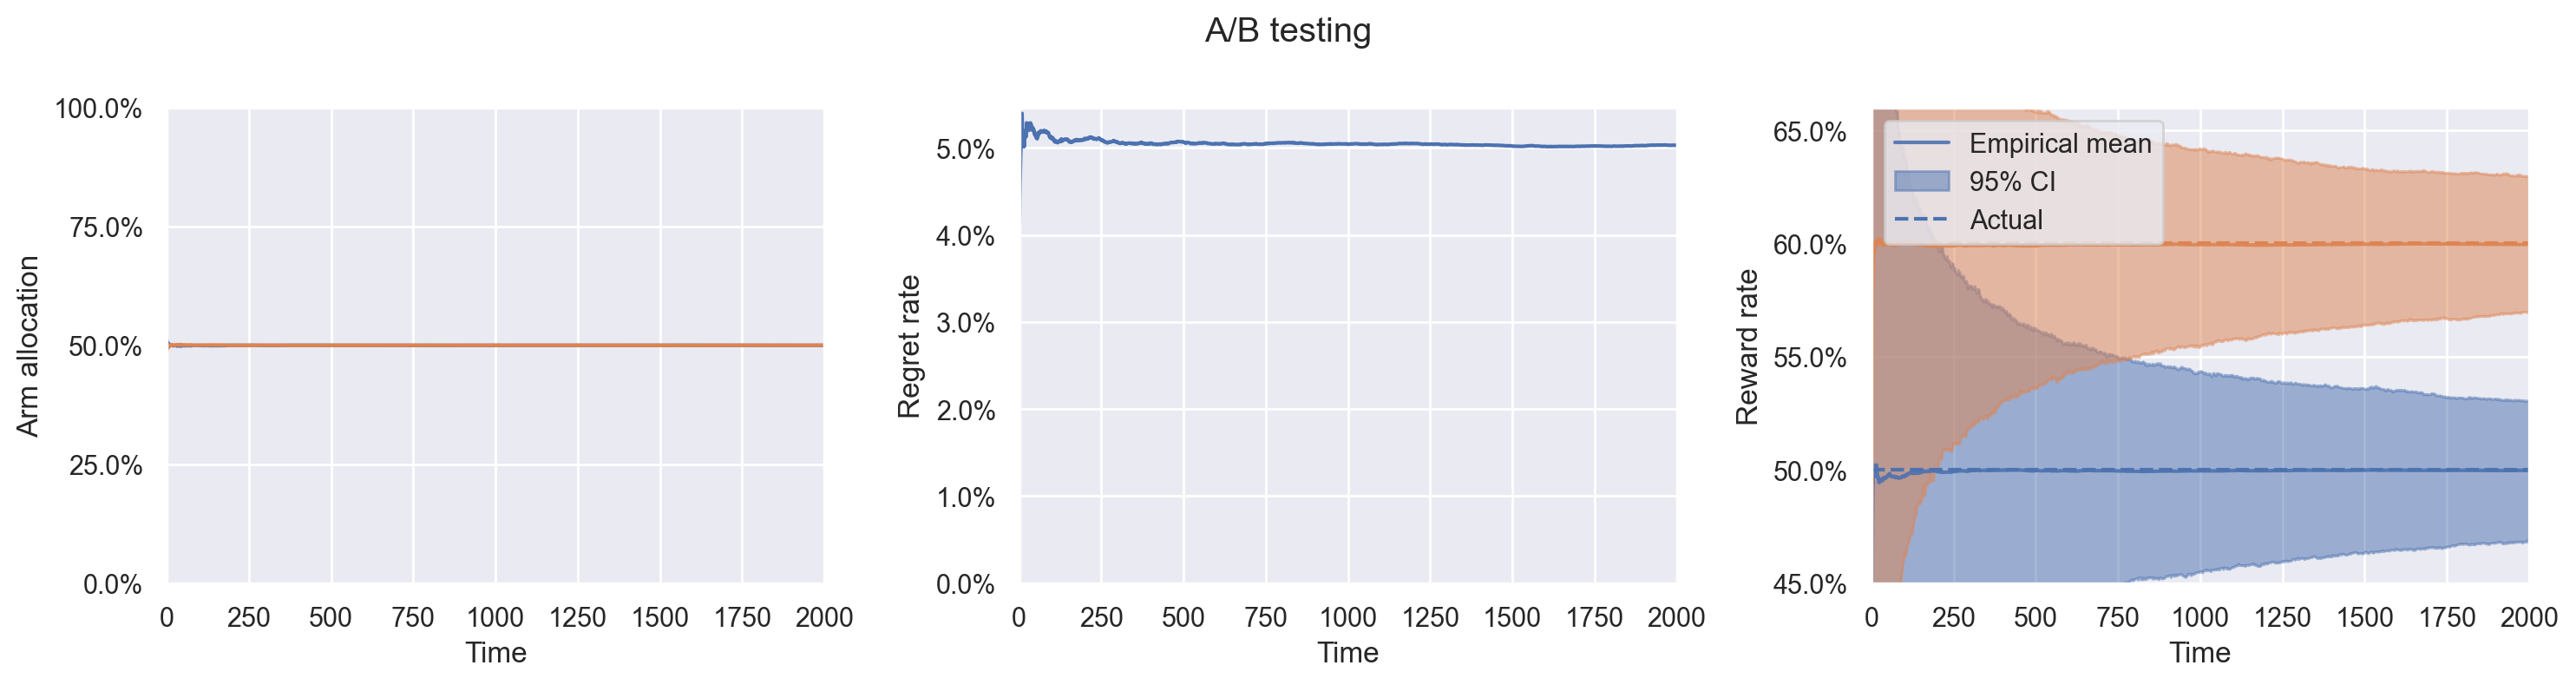

In [38]:
fig = plot_policy(ab_test_reward)

fig.suptitle("A/B testing");
fig.tight_layout();

### $\varepsilon$-greedy

We now turn to policies that attempt to reduce regret, starting with the [$\varepsilon$-greedy algorithm](https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).  This policy acts like an A/B test for a fixed proportion ($\varepsilon$) of samples, and [greedily](https://en.wikipedia.org/wiki/Greedy_algorithm) chooses the arm with the highest empirical reward rate for the remaining $1 - \varepsilon$ proportion of samples.  The actions taken due to random sampling serve to improve the estimate of the reward rates of each arm (exploring) and the actions taken due to greediness attempt to maximize the rewards received (exploiting).

Before implementing the $\varepsilon$-greedy strategy itself, we define two decorators that will be useful throughout the rest of the post.  The first decorator, `initial_explore`, tries each arm once in sequence at the beginning of the simulation.  This behavior is generally useful for making sure each arm has a well-defined empirical reward rate before we start applying the actual policy's logic to choose actions.

In [39]:
@decorator
def initial_explore(policy, t, arm_ct, arm_reward_ct, **policy_kwargs):
    n_sim, n_arm = arm_ct.shape
    
    if t < n_arm:
        return np.full((n_sim, 1), t)
    else:
        return policy(t, arm_ct, arm_reward_ct, **policy_kwargs)

The second decorator, `ε_explore`, choose a random arm (similary to A/B testing), a fixed proportion (`ε`) of the time.

In [40]:
@decorator
def ε_explore(policy, t, arm_ct, arm_reward_ct, *, ε, rng, **policy_kwargs):
    n_sim, n_arm = arm_ct.shape
    
    explore = rng.uniform(size=(n_sim, 1)) < ϵ
    explore_arm = ab_test(t, arm_ct, arm_reward_ct, rng=rng)
    policy_arm = policy(t, arm_ct, arm_reward_ct, rng=rng, **policy_kwargs)
    
    return np.where(explore, explore_arm, policy_arm)

Applying these two decorators to a greedy policy gives us the $\varepsilon$-greedy alogrithm described above.

In [41]:
def greedy(_, arm_ct, arm_reward_ct, **__):
    return (arm_reward_ct / arm_ct).argmax(axis=-1, keepdims=True)

ε_greedy = initial_explore(ε_explore(greedy))

We now simulate the behavior of this policy for $\varepsilon = 0.05$.

In [42]:
EPSILON = 0.05

In [43]:
ε_greedy_reward = simulate_policy(ε_greedy, reward, ε=EPSILON, rng=rng, progress=True)

As expected, we do see arm allocation percentages that shift quickly away from 50/50 and a declining regret rate.  Note that there is a non-zero lower bound on the regret rate given by $\frac{\varepsilon}{2}$ times the absolute difference in arm reward rates.

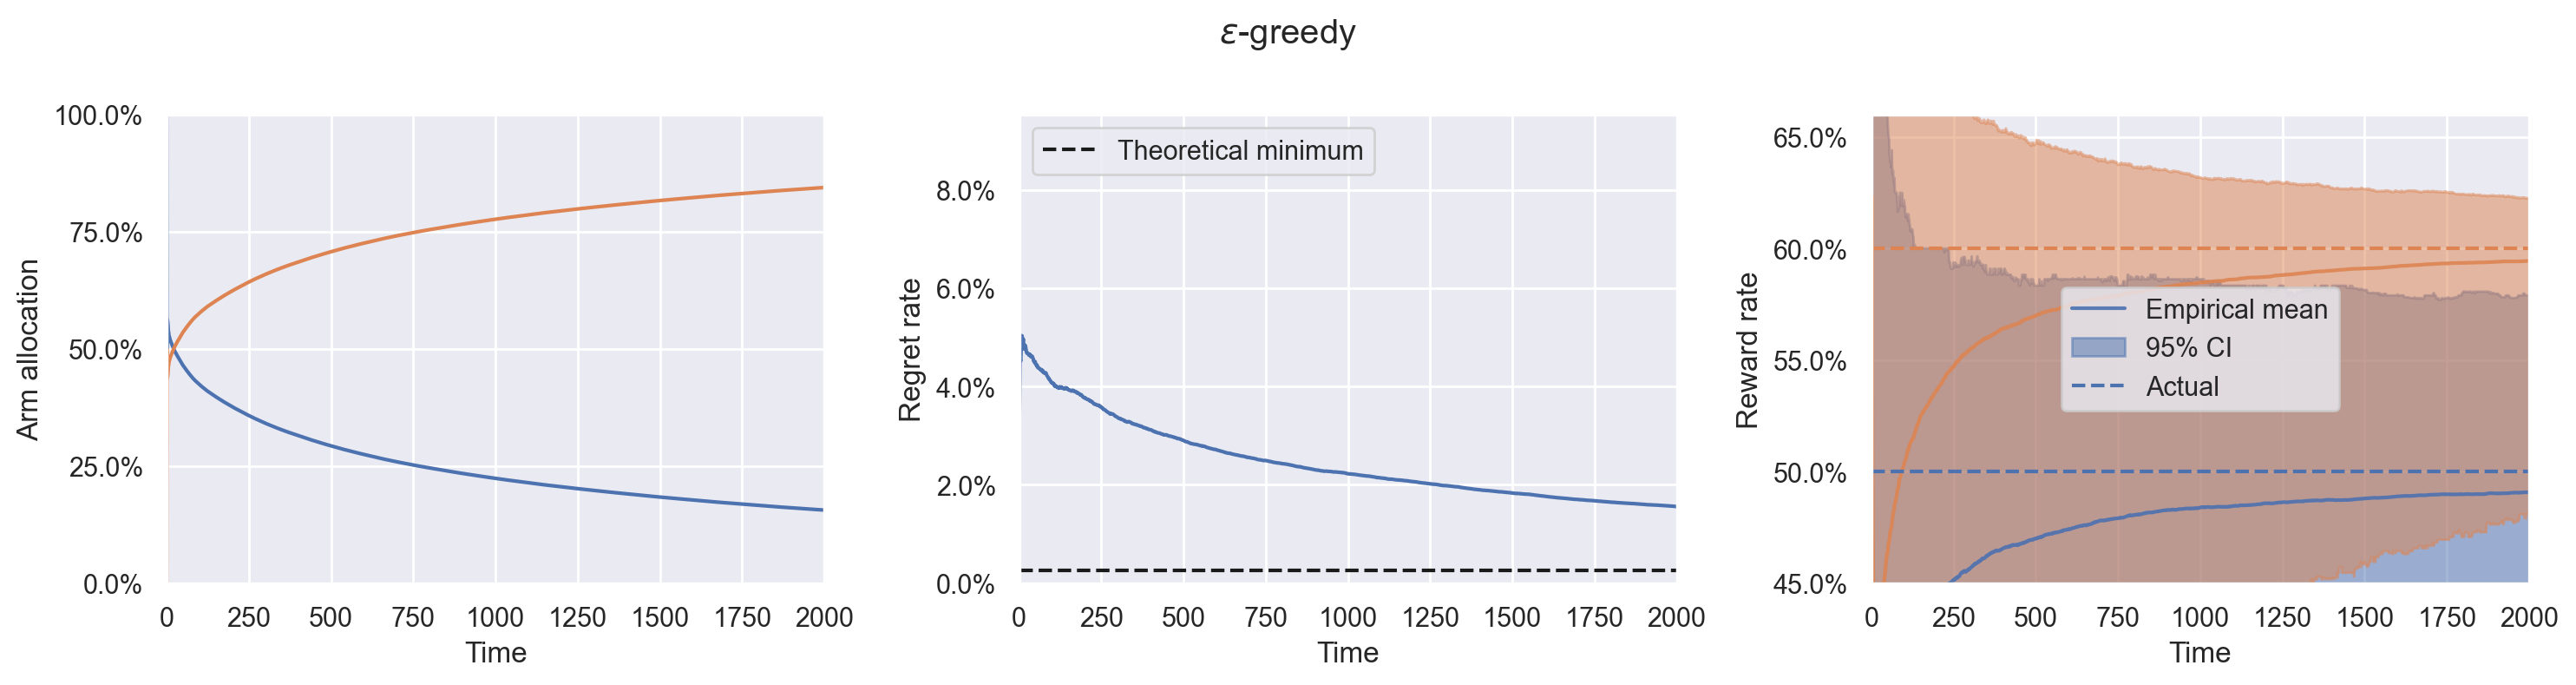

In [44]:
fig = plot_policy(ε_greedy_reward)

regret_ax = fig.axes[1]
regret_ax.axhline(EPSILON / 2 * np.abs(ARM_RATES.ptp()),
                  c="k", ls="--", label="Theoretical minimum");
regret_ax.legend(loc="upper left");

fig.suptitle(r"$\varepsilon$-greedy");
fig.tight_layout();

The most interesting result of this simulation is in the rightmost plot, which is shown larger below for closer examination.

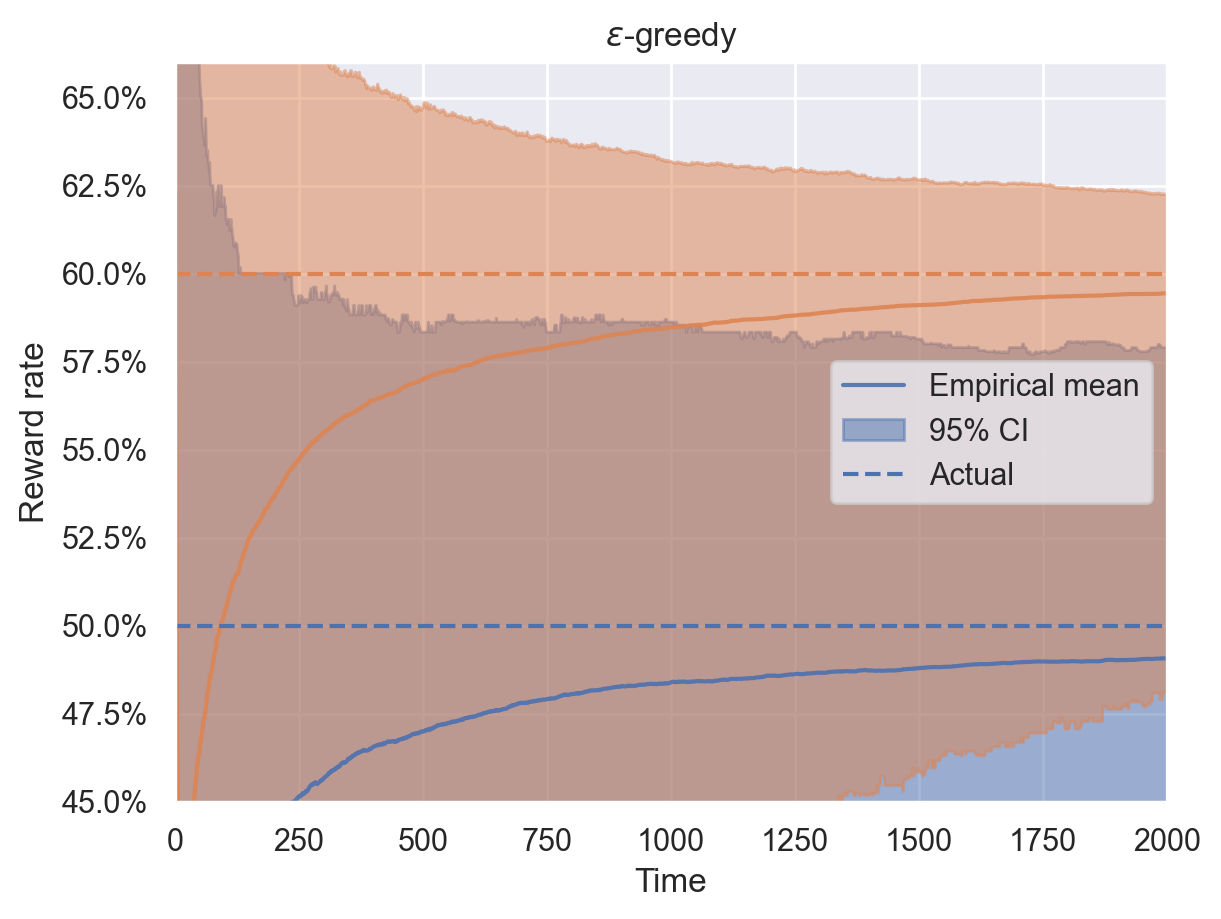

In [45]:
ax = plot_cum_arm_reward_rate(ε_greedy_reward)

ax.legend();
ax.set_title(r"$\varepsilon$-greedy");

There are two notable differences between this plot and the corresponding one for A/B testing:

* The first is that the $\varepsilon$-greedy policy **does not produce unbiased empirical estimates of the arm reward rates.** We will spend most of the rest of this post grappling with this fact and its implications.
*  The second is that the 95% confidence interval for the arm with the lower reward rate is much wider than that of the arm with the higher reward rate.

The second difference is illustrated below, and is easier to explain.

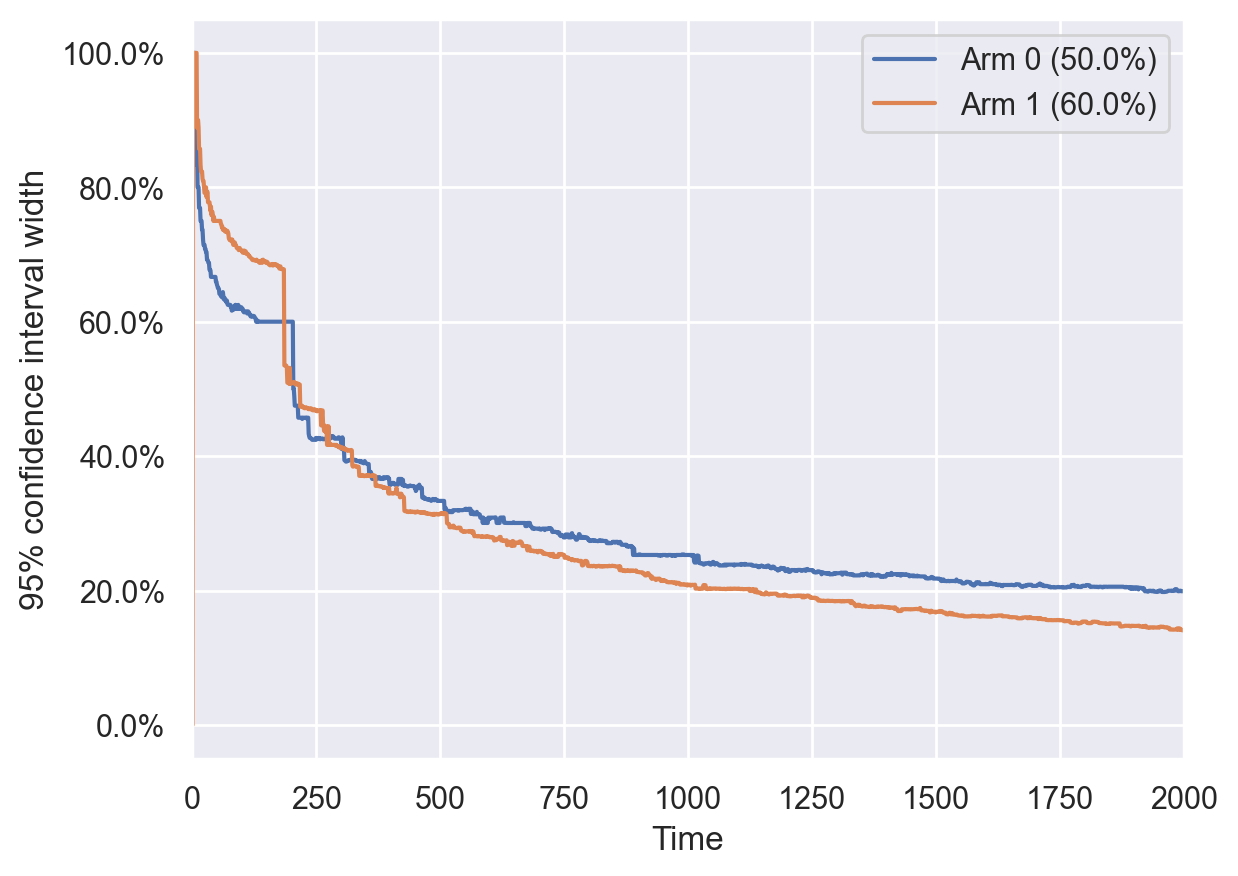

In [46]:
fig, ax = plt.subplots()

ε_greedy_cum_arm_reward_rate = cum_arm_reward_rate(ε_greedy_reward)

alpha = 1 - CI_WIDTH
q = [100 * alpha / 2, 100 * (1 - alpha / 2)]

ax.plot(
    get_time(reward),
    np.diff(np.percentile(ε_greedy_cum_arm_reward_rate, q, axis=0), axis=0)
        .squeeze()
        .T,
    label=ARM_LABELS
);

make_time_axis(ax);
make_pct_axis(ax, label=f"{CI_WIDTH:.0%} confidence interval width", full=False);

ax.legend();

The adaptive nature of the policy leads to the arm with the lower reward rate being selected (on average) much less often, so there are fewer samples of its performance.  This smaller sample size leads to more variance in the estimate and a wider confidence interval.

To understand the first point, we carefully examine the proof that the empirical estimate produced by A/B testing is unbiased.  By definition, for A/B testing, the arm chosen at time $t$ is indepdent of the rewards observed prior to time $t$, which is $\mathbf{x}_{t - 1}$, so $x_{i, t}$ is independent of $n_{i, t}$, and


$$
\mathbb{E}\left(\hat{r}_{i, t}\right)
    = \mathbb{E}\left(\frac{x_{i, t}}{n_{i, t}}\right)
    = \frac{\mathbb{E}\left(x_{i, t}\right)}{\mathbb{E}\left(n_{i, t}\right)}.
$$

It is crucial to the final step that $x_{i, t}$ is indepdenent of $n_{i, t},$ and the fact that this independence does not hold for adaptive policies is directly responsible for the bias we have seen above.

Under our assumption that $r_i \sim \operatorname{Ber}(p_i)$, for any policy we have that $\mathbb{E}\left(x_{i, t}\right) = p_i \cdot \mathbb{E} \left(n_{i, t}\right)$, so for A/B testing

$$
\mathbb{E}\left(\hat{r}_{i, t}\right)
    = \mathbb{E}\left(\frac{x_{i, t}}{n_{i, t}}\right)
    = \frac{\mathbb{E}\left(x_{i, t}\right)}{\mathbb{E}\left(n_{i, t}\right)}
    = \frac{p_i \cdot \mathbb{E}\left(n_{i, t}\right)}{\mathbb{E}\left(n_{i, t}\right)}
    = p_i,
$$

and the emprical estimator of the reward rate is unbiased.

For an adaptive policy, like $\varepsilon$-greedy, that uses past observed rewards to choose the next arm, it is not longer the case that

$$n_{i, t} = \sum_{s=1}^t \mathbb{1}\{f(s, \mathbf{n}_{s - 1}, \mathbf{x}_{s - 1}) = a_i\}$$

is independent of $x_{i, t}$, so (in general)

$$
\mathbb{E}\left(\hat{r}_{i, t}\right)
    = \mathbb{E}\left(\frac{x_{i, t}}{n_{i, t}}\right)
    \neq \frac{\mathbb{E}\left(x_{i, t}\right)}{\mathbb{E}\left(n_{i, t}\right)}
    = p_i,
$$

and the empirical estimator is no longer unbiased.  Here $\mathbb{1}\{E\}$ is the indicator function

$$
\mathbb{1}\{E\} = \begin{cases}
    1 & \textrm{if the event } E\textrm{ occurred} \\
    0 & \textrm{otherwise}
\end{cases}.
$$

While understanding this formal justification for the bias of the empirical estimator for adaptive policies is important, the following explanation is much more intuitive.  Due to the stochastic nature of the rewards, $r_i \sim \operatorname{Ber}(p_i)$, at each point in time the empirical estimate $\hat{r}_{i, t}$ will usually be either above or below the true value of $p_i$.

* When we have an **overestimate** and $\hat{r}_{i, t} > p_i$, it is **relatively more likely** that a sensible adaptive policy will choose $a_i$ next, so we will get more samples from arm $i$, and its empirical reward rate will **regress towards to mean relatively quickly**.
* When we have a **underestimate** and $\hat{r}_{i, t} < p_i$, it is **relatively less likely** that a sensible adaptive policy will choose $a_i$ next, so we will get fewer samples from arm $i$, and its empirical reward rate will **regress towards to mean relatively slowly**.

This argument shows that overestimates will be corrected towards the reward rate faster than underestimates, leading to empirical reward rate estimates that are biased to be smaller than the true reward rates.  It is important that this argument is not specific to the $\varepsilon$-greedy policy, but applies to any *sensible* policy that attempts to minimize regret based on past rewards.

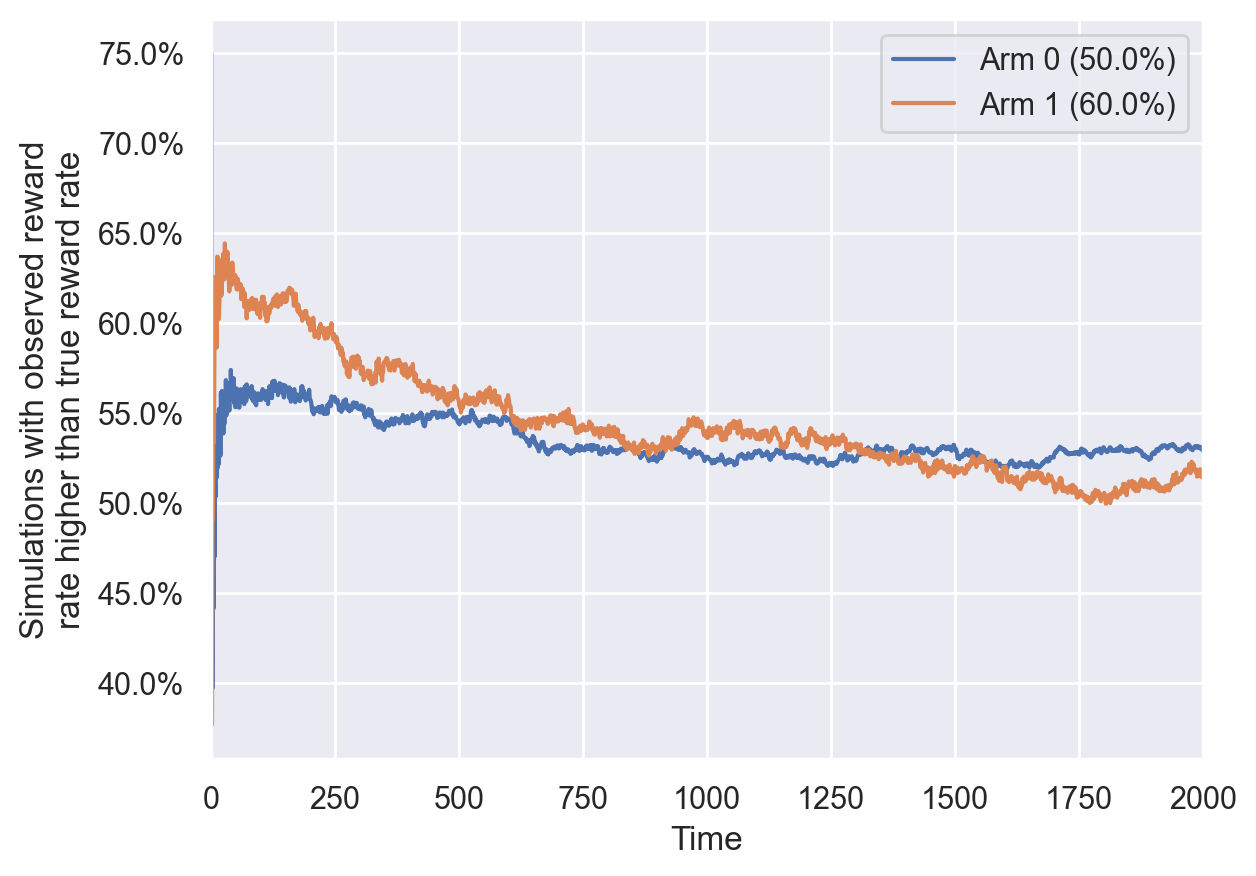

In [47]:
fig, ax = plt.subplots()

ax.plot(
    get_time(reward),
    (ε_greedy_cum_arm_reward_rate < ARM_RATES[np.newaxis, :, np.newaxis])
        .mean(axis=0)
        .clip(0, 0.75)
        .T,
    label=ARM_LABELS
);

make_time_axis(ax);
make_pct_axis(
    ax,
    label="Simulations with observed reward\nrate higher than true reward rate",
    full=False
);

ax.legend();

The plot above illustrates this phenomenon.  Although the number of simulations in which the empirical estimate of the observed reward rate is an underestimate starts out higher for the better arm, it declines much more quickly for that arm than the worse one.

When I first started prototyping mutli-armed bandit products for digital marketing years ago, this behavior surprised me, and it took me quite a while both to convince myself that my simulations didn't contain a subtle bug (I rewrote them from scratch several times) and to develop intuition about why this bias occurs.

### UCB1

As noted above, these arguments only rely on the adaptive nature of the policy, not the specifics of the policy itself.  In this section and the next we will see that this bias does in fact persist (although its magnitude will vary) for two other policies.

The $\varepsilon$-greedy algorithm discussed above is the simplest intuitive adaptive multi-armed bandit algorithm, in the sense that it does not rely on any statistics of even moderate sophistication. Using [Hoeffding's inequality](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality) on the deviation of a sum of i.i.d. random variables from their mean, we can arrive at the "Upper Confidence Bound 1" (UBC1) algorithm.  For a detailed discussion of this algorithm, refer to this excellent [post](https://www.jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/) by Jeremy Kun.  The UCB1 algorithm proceeds as follows:

* Try each arm once.
* After trying each arm once, calculate the upper confidence bound (derived from Hoeffding's inequality)
$$\hat{u}_{i, t} = \hat{r}_{i, t} + \sqrt{2 \cdot \frac{\log t}{n_{i, t}}}$$
for each arm.  Choose the arm with the highest upper confidence bound.

The first point above ensures there is enough data for the upper confidence bound in the second point to be defined by trying each arm once before proceeding to adaptive allocation.

The following function implements the UCB1 algorithm.

In [48]:
@initial_explore
def ucb1(t, arm_ct, arm_reward_ct):
    ucb = arm_reward_ct / arm_ct + np.sqrt(2 * np.log(t) / arm_ct)

    return ucb.argmax(axis=-1, keepdims=True)

We now simulate the behavior of this policy and visualize its performance.

In [49]:
ucb1_reward = simulate_policy(ucb1, reward, progress=True)

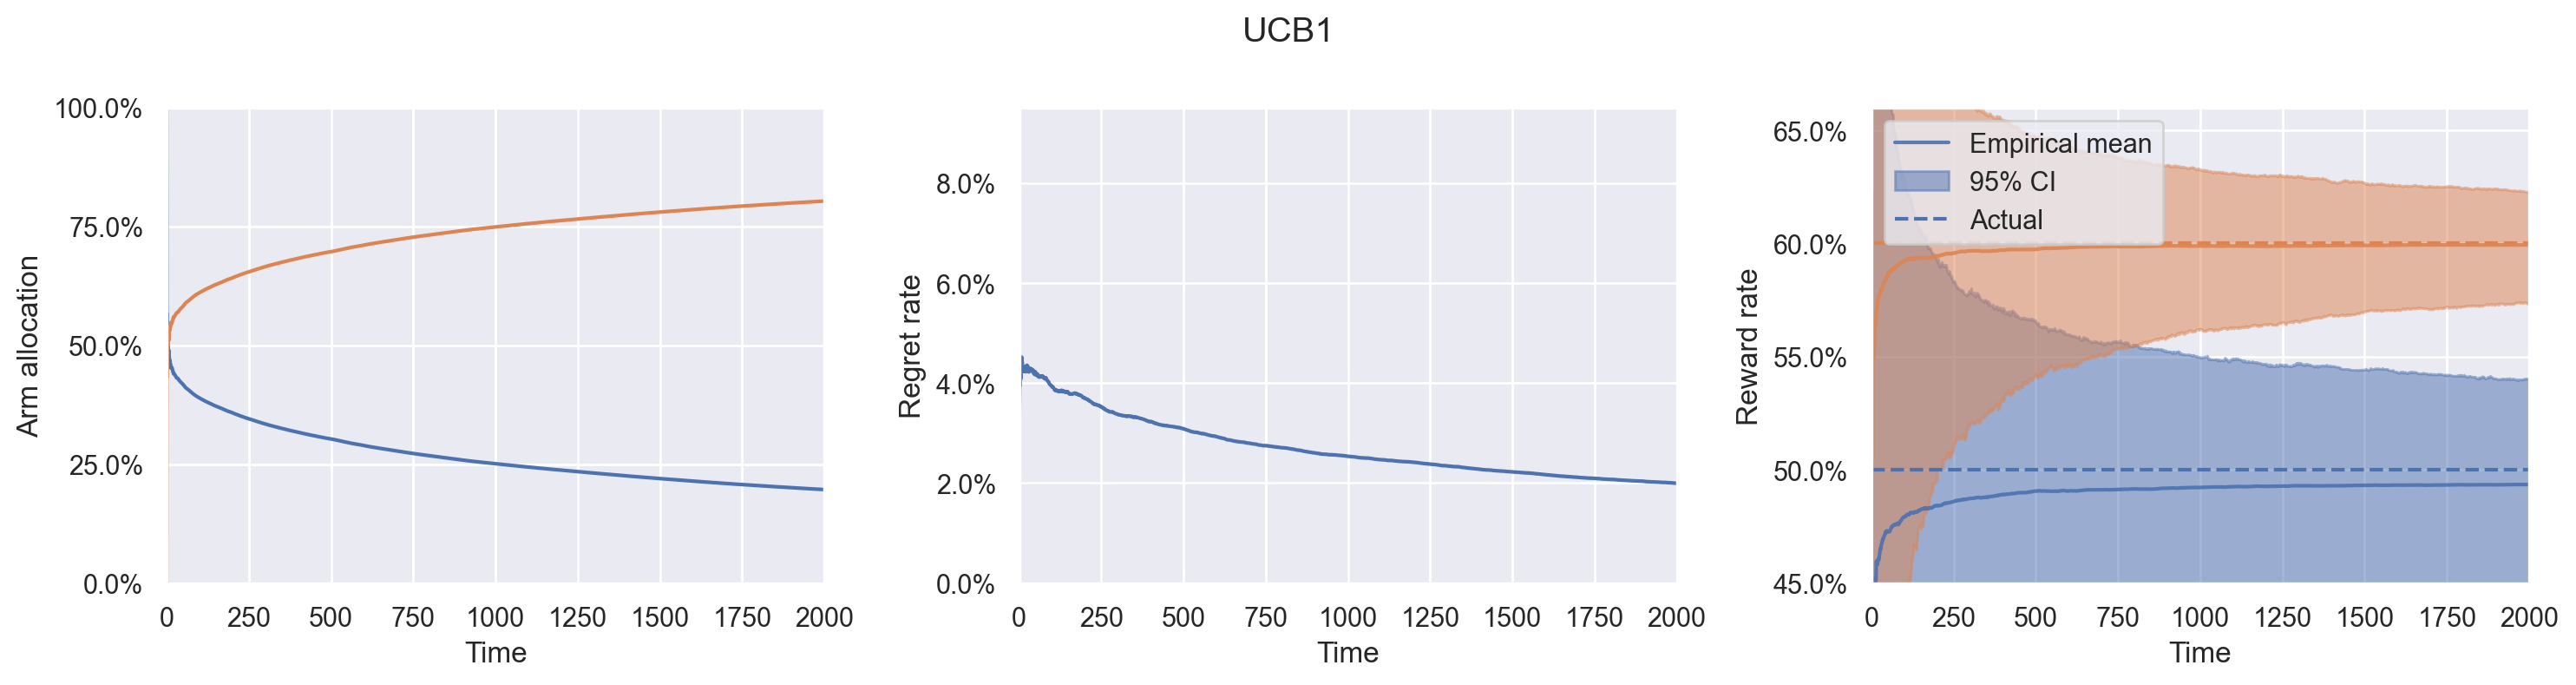

In [50]:
fig = plot_policy(ucb1_reward)

fig.suptitle("UCB1");
fig.tight_layout();

In the third plot, we see confirmation that the UCB1 algorithm produces empirical estimators with directionally similar bias.

It is instructive to compare each of these plots between $\varepsilon$-greedy and UCB1 algorithms.

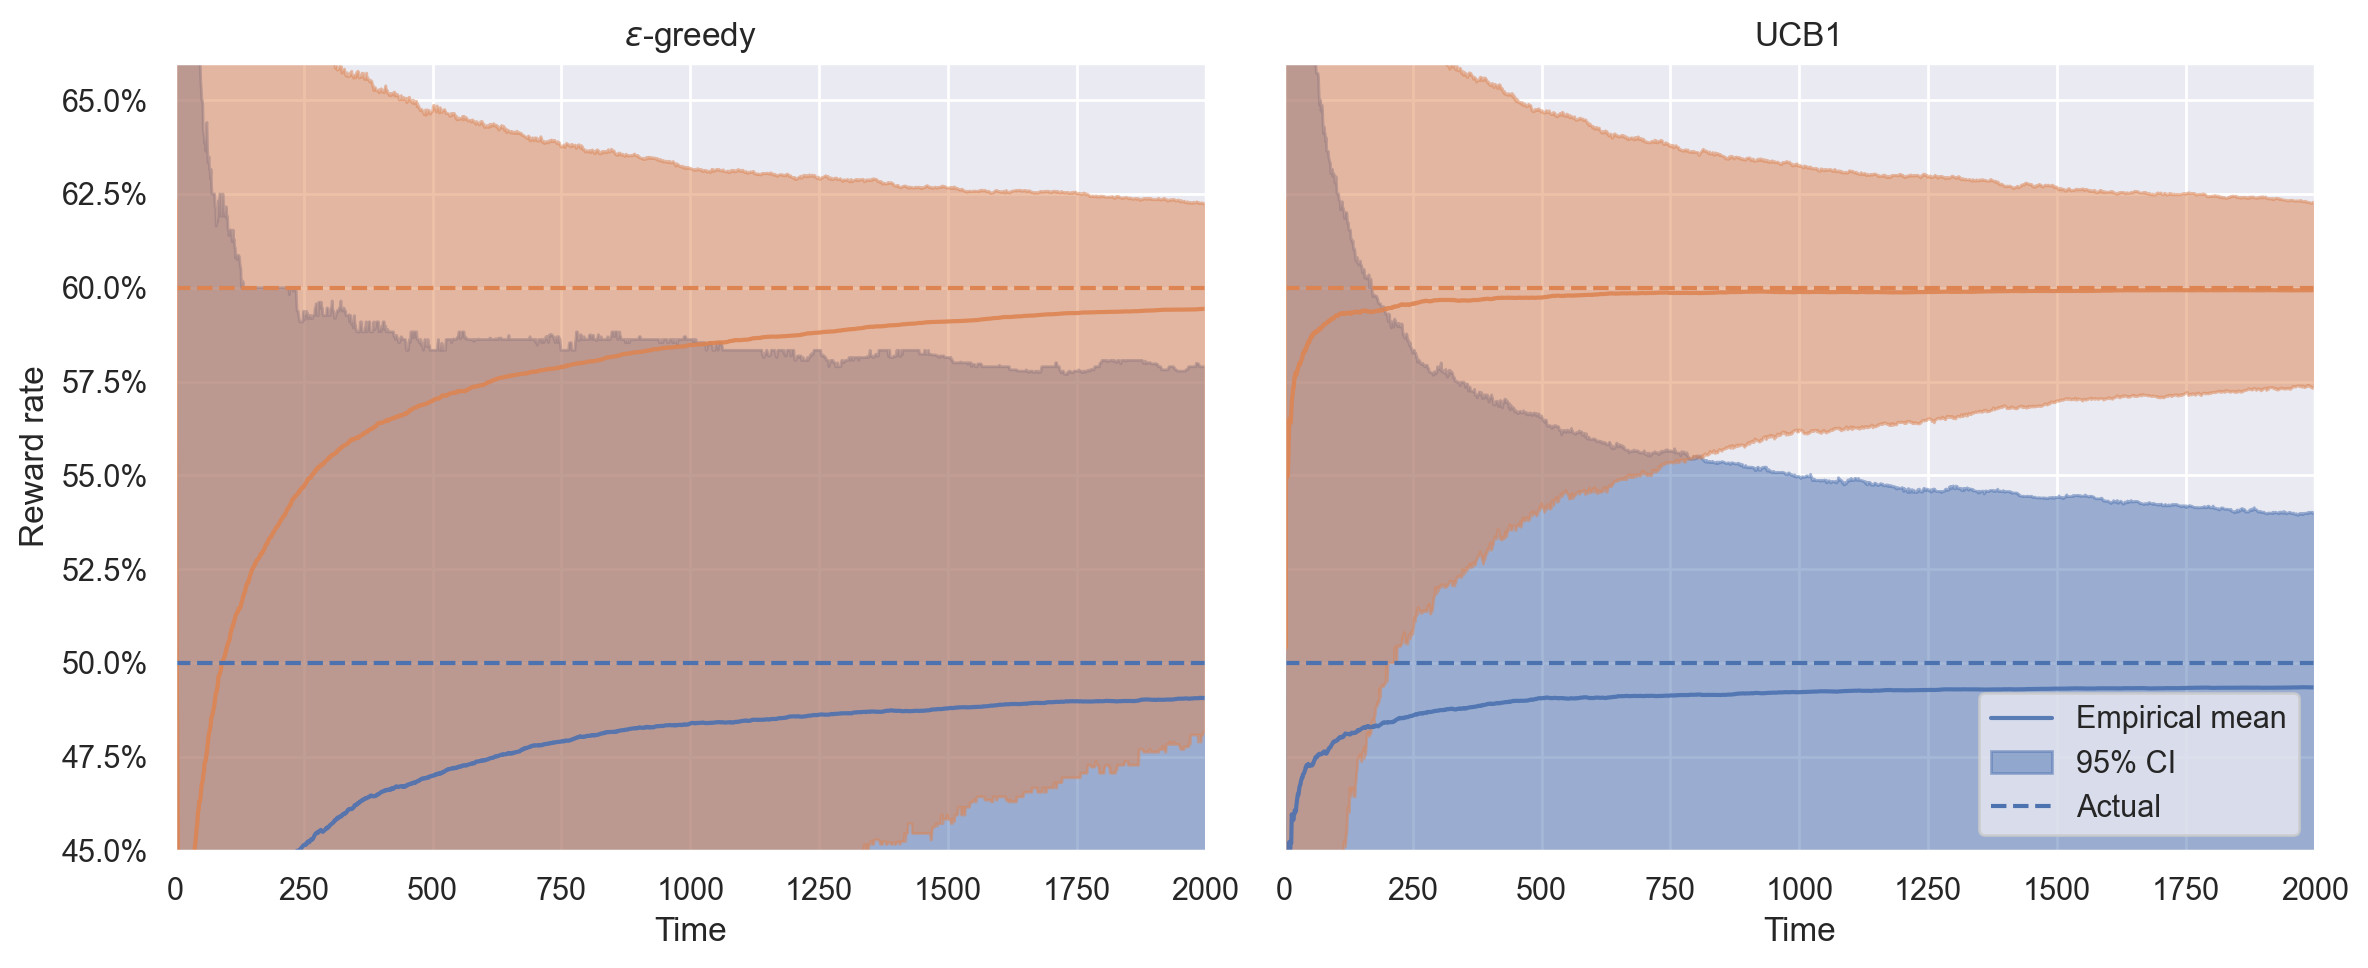

In [51]:
fig, (ε_ax, ucb1_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 5))

plot_cum_arm_reward_rate(ε_greedy_reward, ax=ε_ax);
plot_cum_arm_reward_rate(ucb1_reward, ax=ucb1_ax);

ε_ax.legend().set_visible(False);
ε_ax.set_title(r"$\varepsilon$-greedy");

ucb1_ax.set_ylabel(None);
ucb1_ax.set_title("UCB1");

fig.tight_layout();

We see that, compared to the $\varepsilon$-greedy algorithm, the UCB1 algorithm's empirical estimate of the better arm's reward rate converges to the true value faster.  Also, the confidence intervals for UCB1 are smaller.

We can understand the different magnitude of bias (and width of confidence intervals) by examining the arm allocations for each algorithm.

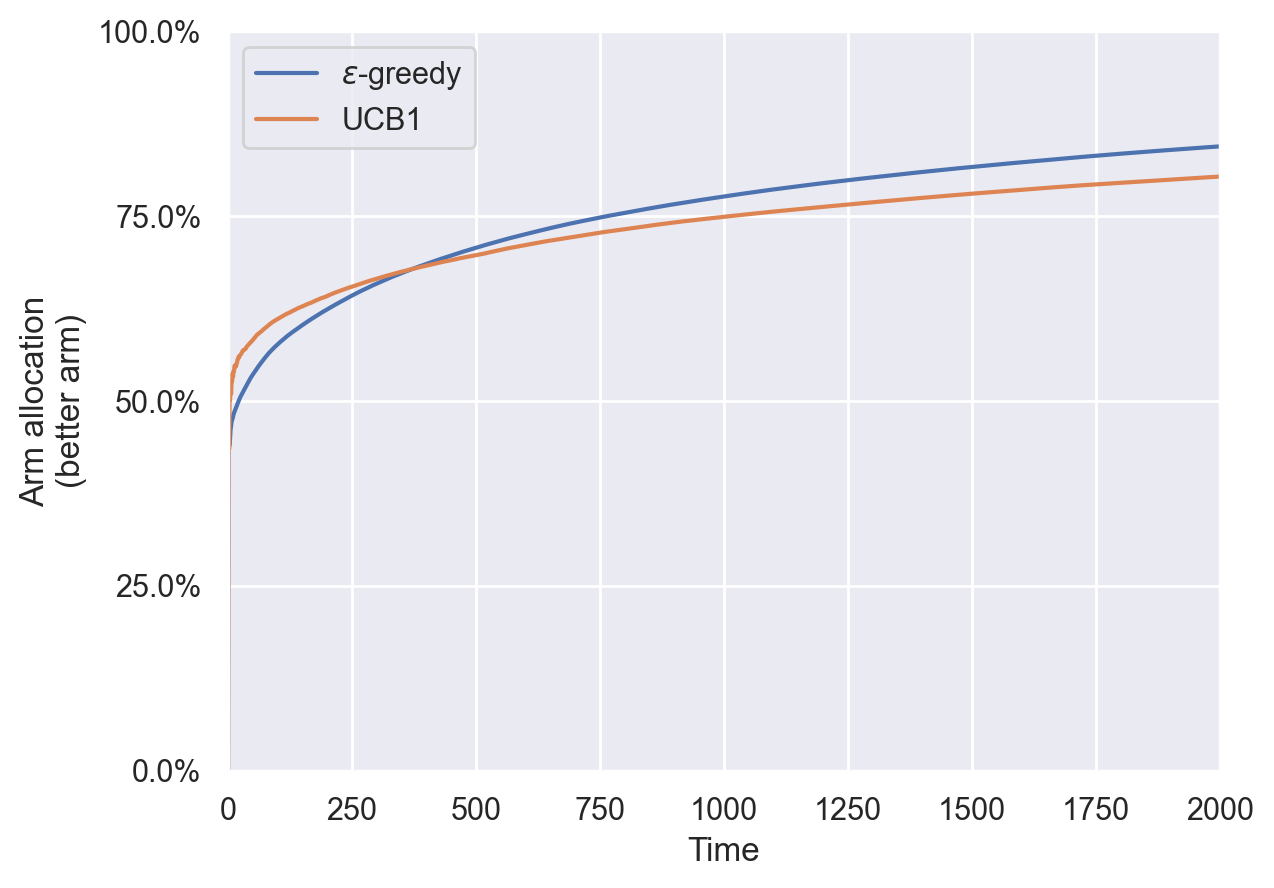

In [52]:
fig, ax = plt.subplots()

plot_arm_allocation(ε_greedy_reward[:, ARM_RATES.argmax()],
                    label=r"$\varepsilon$-greedy", ax=ax);
plot_arm_allocation(ucb1_reward[:, ARM_RATES.argmax()],
                    label="UCB1", ax=ax);

ax.set_ylabel("Arm allocation\n(better arm)");

ax.legend();

We see that initially the UCB1 algorithm allocates more samples to the better performing arm, but over time it reserved more samples for the worse performing arm than the $\varepsilon$-greedy algorithm.  That is, the UCB1 algorithm is more conservative in its balancing of exploration and exploitation in this situation.

There are two complimentary explanations for the thinner confidence intervals for the empirical reward rate estimates for UCB1.  First, UCB1 allocates more samples to the worse-performing arm than $\varepsilon$-greedy.  More samples will generally decrease the width of the confidence interval.

The fact that the UCB1 allocates more samples to the worse-performing arm in the long run is largely responsible for the thinner confidence interval around its reward rate.  Another perspective on the thinner the confidence intervals is that, by allocating more samples to the worse performing arm, UCB1 incurs more regret, as shown below.

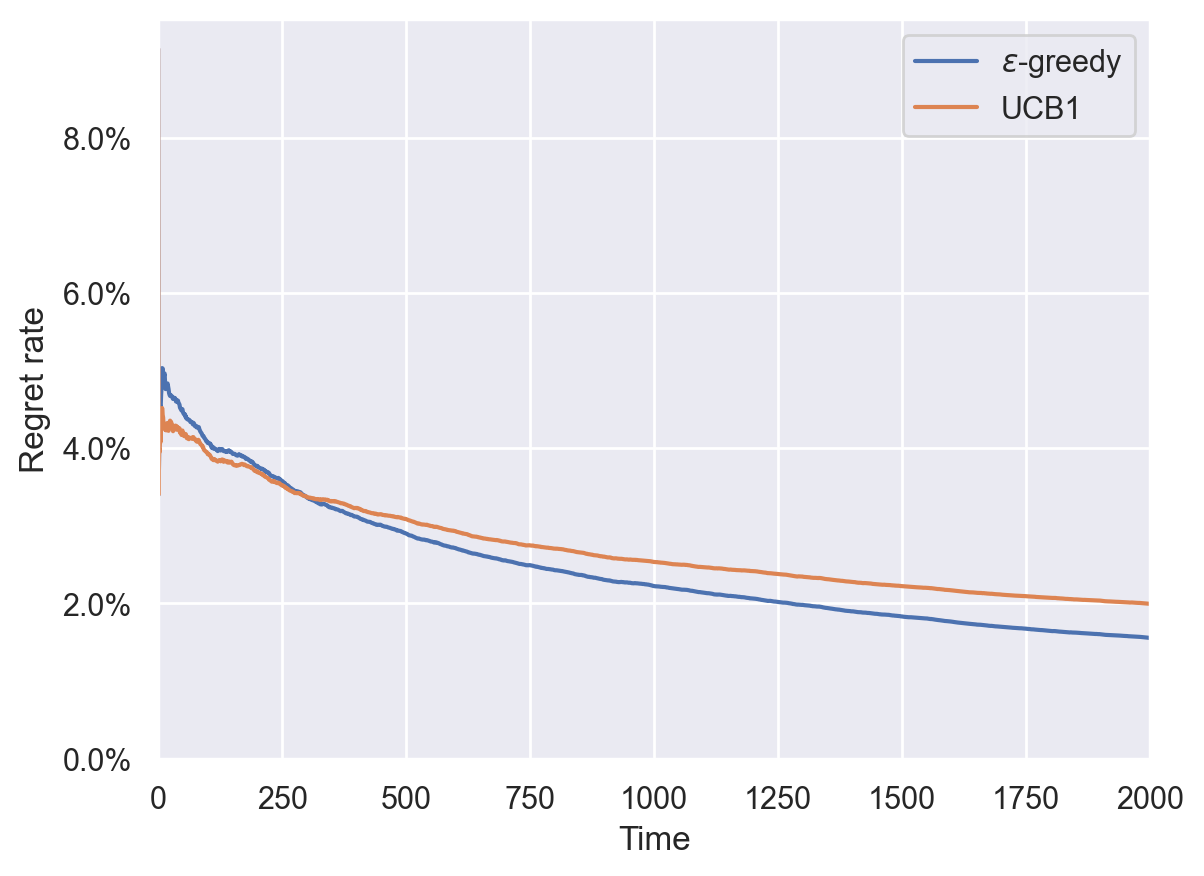

In [53]:
fig, ax = plt.subplots()

plot_cum_regret_rate(ε_greedy_reward, ax=ax, label=r"$\varepsilon$-greedy");
plot_cum_regret_rate(ucb1_reward, ax=ax, label="UCB1");

ax.legend();

This perspective illutrates the tradeoff between regret and bias.  The lower-regret $\varepsilon$-greedy algorithm has higher bias.  We will continue to use these two perspectives on bias throughout the rest of the post.

### Beta-Binomal Thompson Sampling

To round out the policies we will consider in this post, we take a [Bayesian](https://en.wikipedia.org/wiki/Bayesian_statistics) perspective on the multi-armed bandit problem.  The Bayesian approach starts with prior distributions on the unknown reward rates before we collect any data.  In this case, we use a uniform prior distribution, $r_{i, 0} \sim U(0, 1)$, for simplicity.  After time $t$, where we have seen $x_{i, t}$ rewards from arm $i$ in $n_{i, t}$ attempts, we have that

$$x_{i, t}\ |\ n_{i, t}, r_{i, 0} \sim \textrm{Bin}(n_{i, t}, r_{i, 0}),$$

based on our assumptions above about reward distributions.  The uniform prior distribution combined with this [binomial](https://en.wikipedia.org/wiki/Binomial_distribution) likelihood are [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) and result in the posterior distribution

$$r_{i, t}\ |\ n_{i, t}, x_{i, t} \sim \textrm{Beta}\left(1 + x_{i, t}, 1 + \left(n_{i, t} - x_{i, t}\right)\right),$$

for the unknown reward rate of arm $i$ after time $t$.

To choose the arm to select next, we apply [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) the posterior distributions for each arm's reward rate.  Thompson sampling chooses the next arm according to the posterior probability that each arm is best.  Concretely, if the posterior probability that the first arm has the higher reward rate is 60%, there is a 60% chance that the policy will choose that arm next, and a 40% change that it will choose the other arm.  The idea behind Thompson is elegant, and it only remains to calculate the probability that each arm has the highest reward rate. Using the definition of the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) we have that

$$
\begin{align}
    \mathbb{P}\left(r_{0, t} > r_{1, t}\ | \mathbf{n}_t, \mathbf{x}_t\right)
        & = \int_0^1 \mathbb{P}\left(r_{0, t} > r\ |\ n_{0, t}, x_{0, t}\right) \cdot f_{r_{1, t}}(r\ |\ n_{1, t}, x_{1, t})\ dr \\
        & = \int_0^1 \left(\int_r^1 f_{r_{0, t}}(s\ |\ n_{0, t}, x_{0, t})\ ds\right) \cdot f_{r_{1, t}}(r\ |\ n_{1, t}, x_{1, t})\ dr \\
        & \propto \int_0^1 \left(\int_r^1 s^{1 + x_{0, t}} (1 - s)^{1 + (n_{0, t} - x_{0, t})}\ ds\right) \cdot r^{1 + x_{1, t}} (1 - r)^{1 + (n_{1, t} - x_{1, t})}\ dr.
\end{align}
$$

Unfortunately, this final integral [does not have a closed form solution](https://en.wikipedia.org/wiki/Beta_function#Incomplete_beta_function), so we will instead use a [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method) to approximate this probability.

To illustrate this method, suppose that $r_{0, t} \sim \textrm{Beta}(2, 5)$ and $r_{1, t} \sim \textrm{Beta}(3, 4)$.  To approximate $\mathbb{P}(r_{0, t} > r_{1, t})$, we first draw 1,000 samples each from each random variable's distribution.

In [54]:
N_MC = 1_000

In [55]:
mc_reward0 = rng.beta(2, 5, size=N_MC)
mc_reward1 = rng.beta(3, 4, size=N_MC)

These samples are illustrated below.

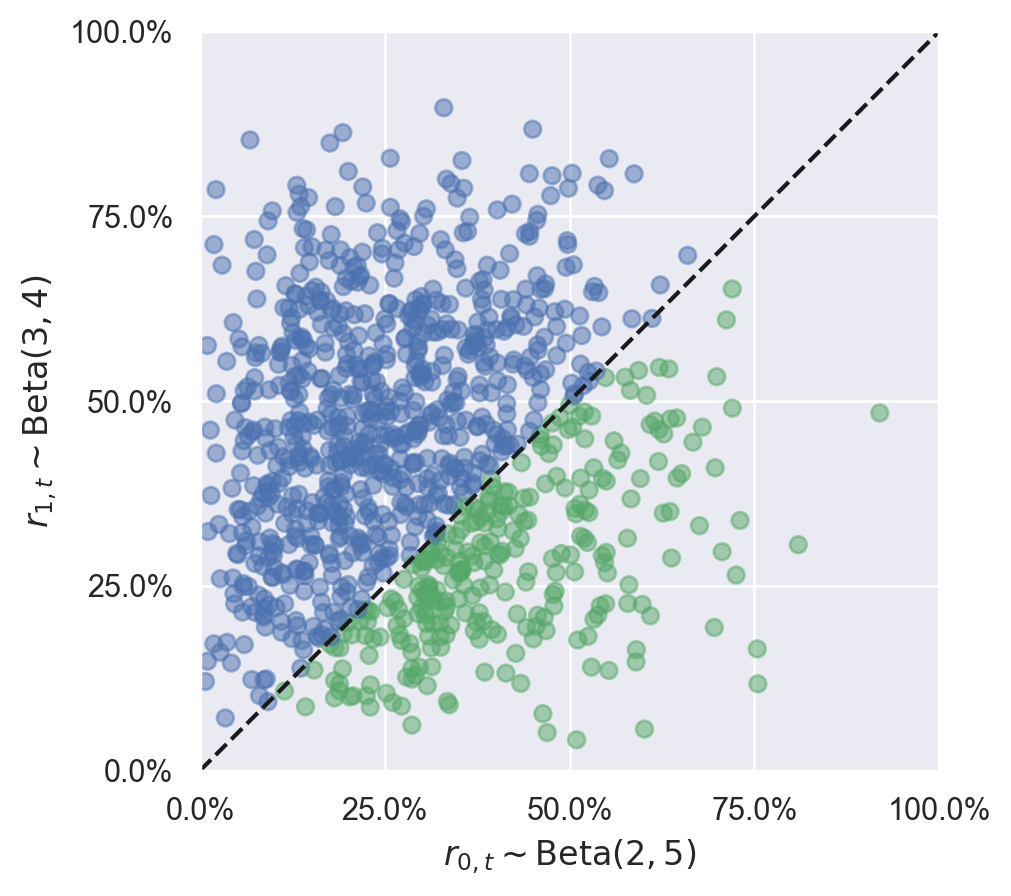

In [56]:
fig, ax = plt.subplots()
ax.set_aspect("equal");

ax.scatter(
    mc_reward0, mc_reward1,
    c=np.where(mc_reward0 > mc_reward1, "C2", "C0"),
    alpha=0.5
);

ax.axline((0, 0), slope=1, c="k", ls="--");

make_pct_axis(ax, label=r"$r_{0, t} \sim \text{Beta}(2, 5)$", which="x");
make_pct_axis(ax, label=r"$r_{1, t} \sim \text{Beta}(3, 4)$", which="y");

To approximate $\mathbb{P}(r_{0, t} > r_{1, t})$, count the proportion of samples that are below the diagonal line $y = x$ in the plot above, shown as green dots.

In [57]:
(mc_reward0 > mc_reward1).mean()

0.272

In this case, there is about a 27% chance that the first arm's reward rate is highest, and therefore about a 27% chance the first arm is selected next.

There is a clever simplification that will reduce the number of samples necessary to choose an arm via Thompson sampling to one per arm.  This simplification relies on the fact that each of the points in the plot above has the correct probability of being above or below the horizontal line.  By generating a single point (one sample from each arm's reward distribution) and choosing the first arm if the point is below the line and the second arm if it is above the line, we will have chosen the next arm according the the probability each is best without explicitly calculating that probability.  This simplification will allow us to scale Thomspon sampling in a straightforward way.  For more details on why this simplification works, see the [prior post](https://austinrochford.com/posts/overthink-mc-pi.html#Overthinking-It) on Monte Carlo estimation.

The following function implements beta-binomial Thompson sampling.

In [58]:
def bb_thompson(_, arm_ct, arm_reward_ct, rng=None):
    samples = rng.beta(1 + arm_reward_ct, 1 + arm_ct - arm_reward_ct)

    return samples.argmax(axis=1, keepdims=True)

We now simulate the behavior of this policy and visualize its performance.

In [59]:
bb_thompson_reward = simulate_policy(bb_thompson, reward, rng=rng, progress=True)

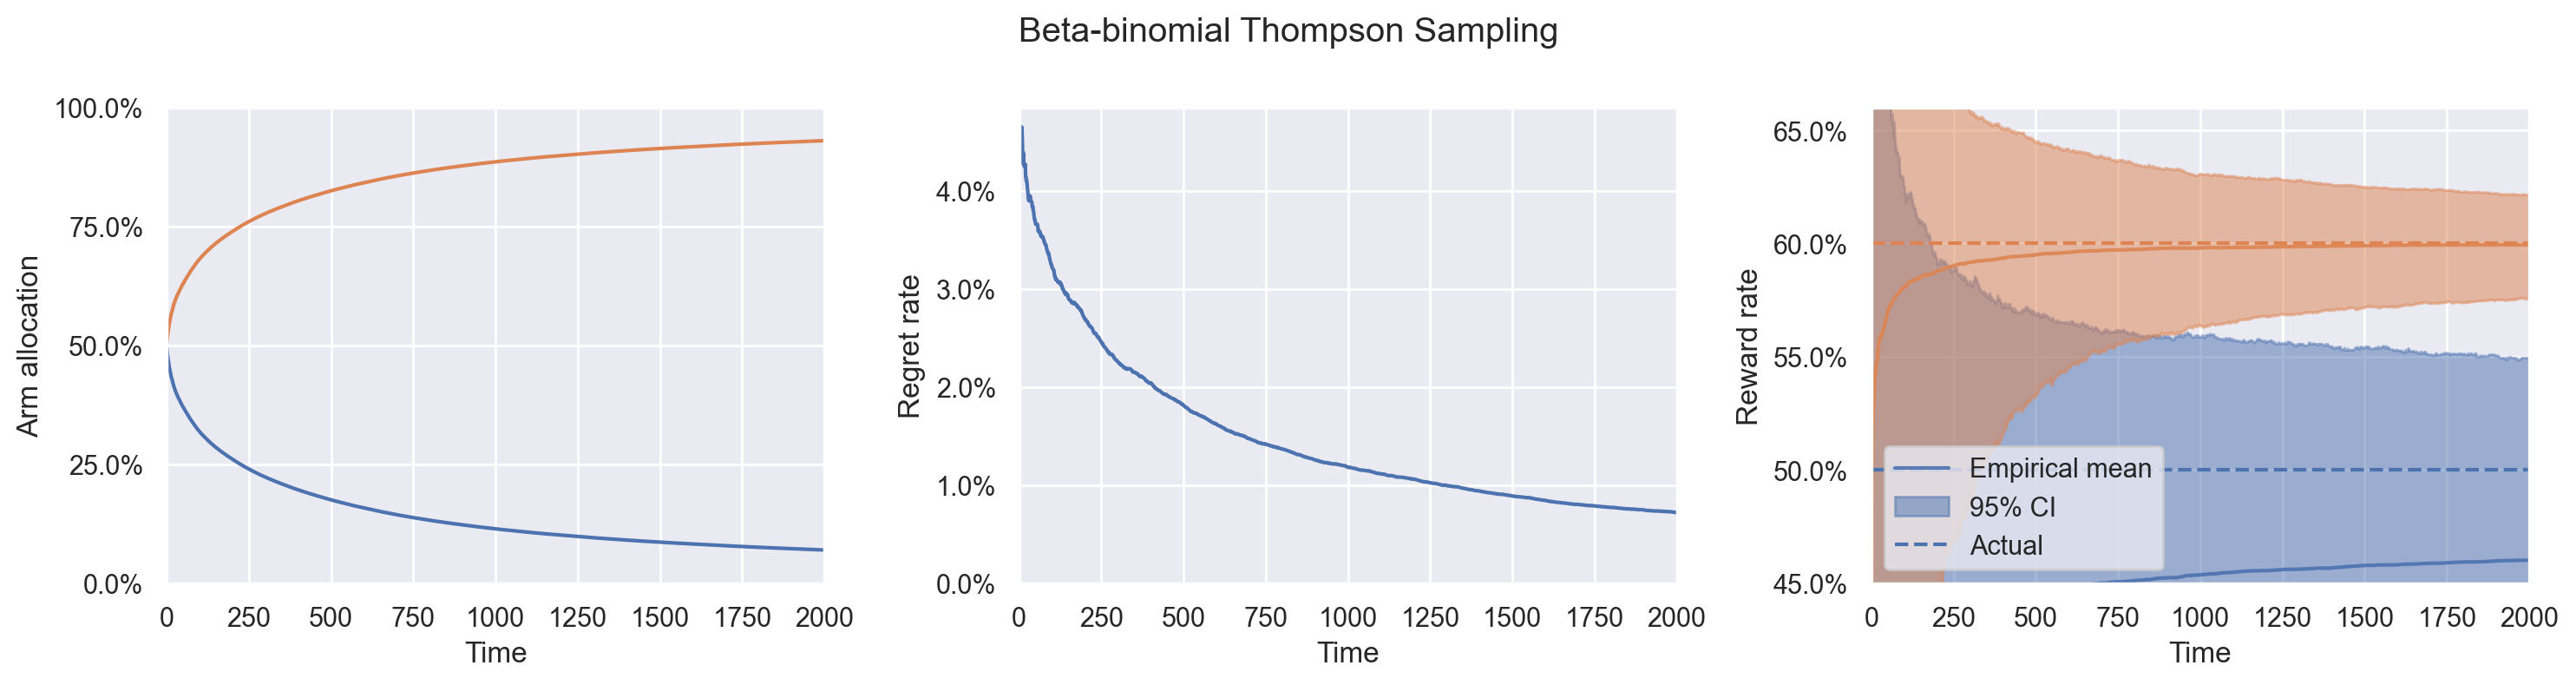

In [60]:
fig = plot_policy(bb_thompson_reward)

fig.suptitle("Beta-binomial Thompson Sampling");
fig.tight_layout();

In the third plot, we see yet again that beta-binomial Thompson sampling produces empirical estimators with directionally similar bias.

It is again instructive to compare each of these plots between the $\varepsilon$-greedy, UCB1, and beta-binomial Thompson sampling algorithms.

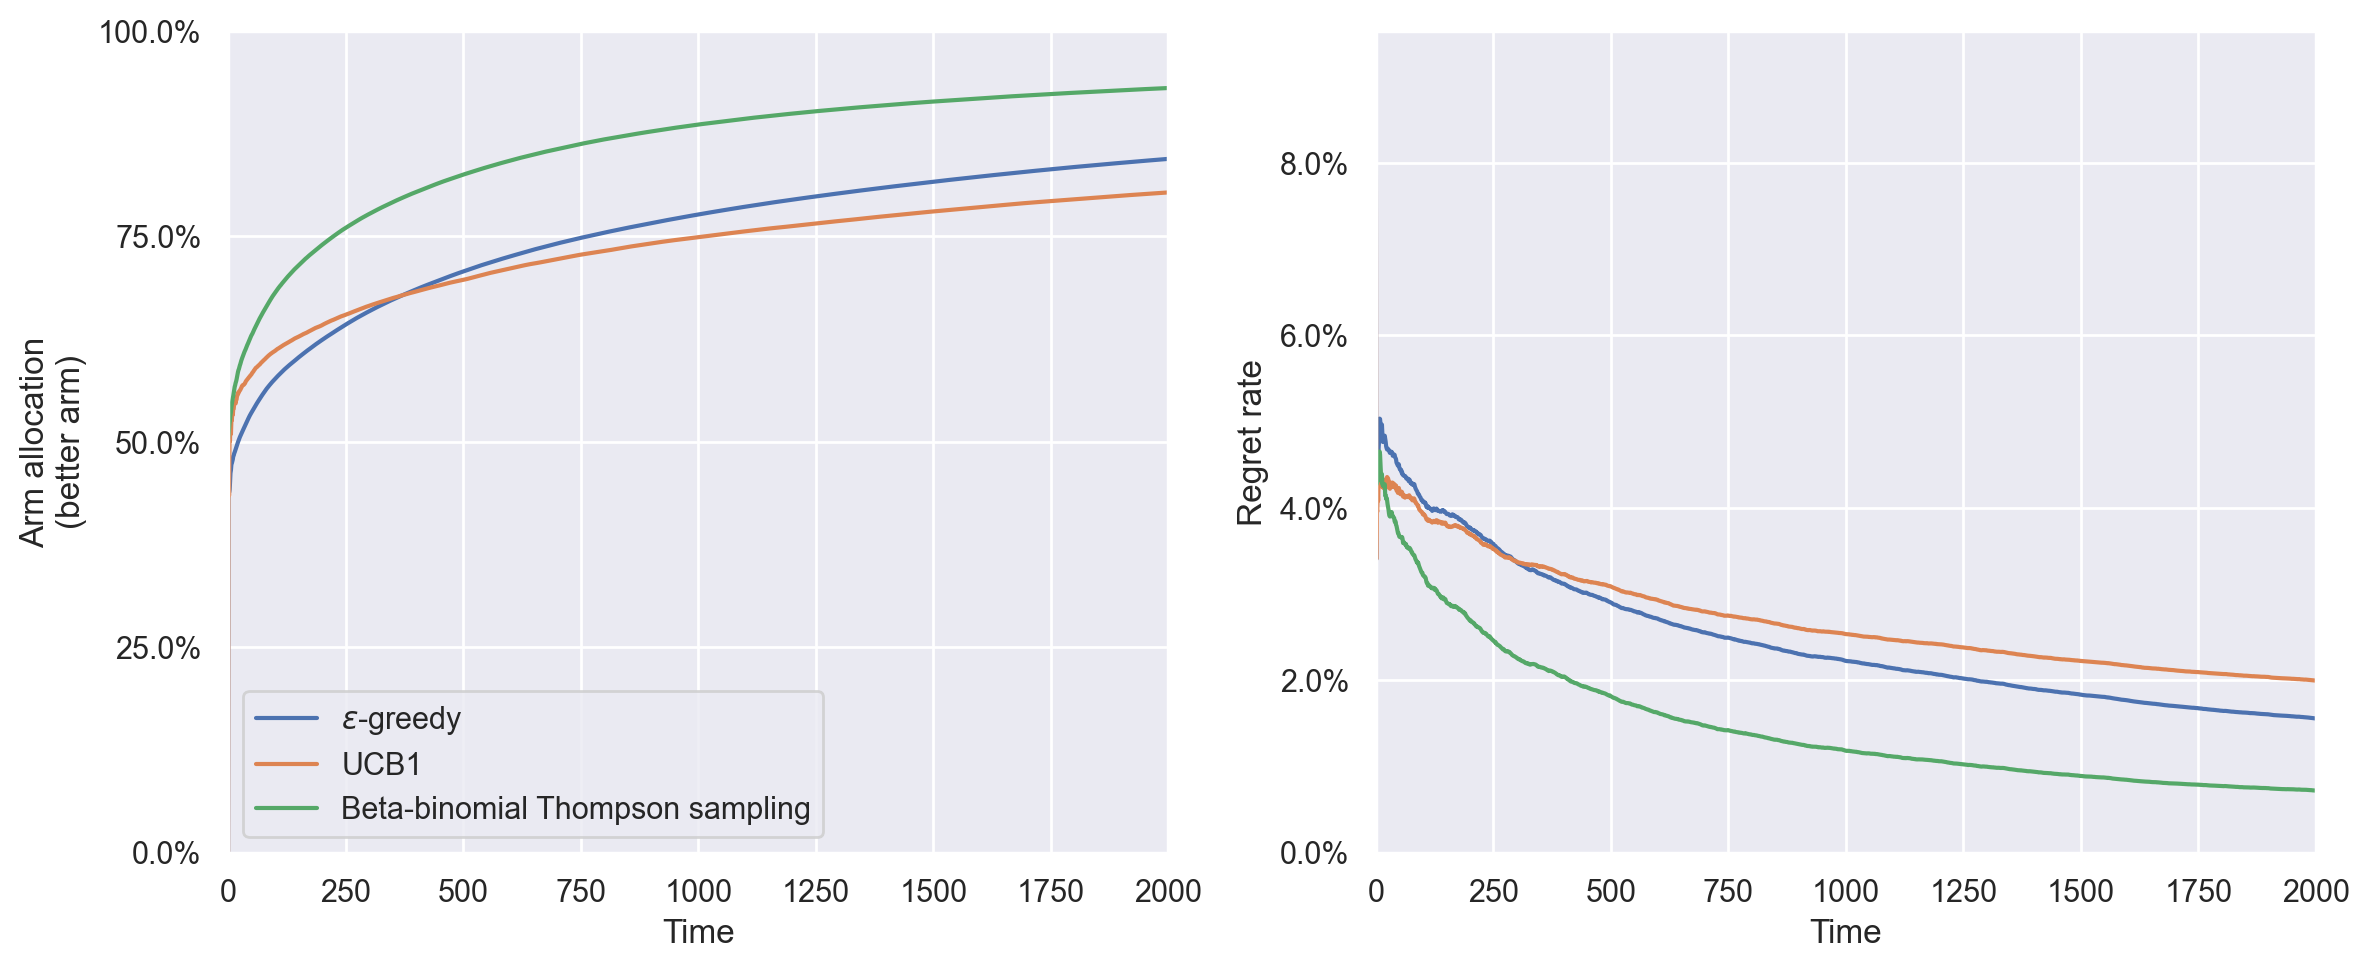

In [61]:
fig, (alloc_ax, regret_ax) = plt.subplots(ncols=2, sharex=True, figsize=(12, 5))

plot_arm_allocation(ε_greedy_reward[:, ARM_RATES.argmax()],
                    label=r"$\varepsilon$-greedy", ax=alloc_ax);
plot_arm_allocation(ucb1_reward[:, ARM_RATES.argmax()],
                    label="UCB1", ax=alloc_ax);
plot_arm_allocation(bb_thompson_reward[:, ARM_RATES.argmax()],
                    label="Beta-binomial Thompson sampling", ax=alloc_ax);

alloc_ax.set_ylabel("Arm allocation\n(better arm)");
alloc_ax.legend();

plot_cum_regret_rate(ε_greedy_reward, ax=regret_ax);
plot_cum_regret_rate(ucb1_reward, ax=regret_ax);
plot_cum_regret_rate(bb_thompson_reward, ax=regret_ax);

fig.tight_layout();

We see that beta-binomial Thompson sampling is the most agressive at allocating samples to the best variant and therefore has the lowest regret rate.

As our experience with the $\varepsilon$-greedy and UBC1 algorithms has shown, since beta-binomial Thompson sampling allocates the most samples to the best arm and therefore the least samples to the worst arm, we expect it to show the most bias in the empirical estimate of the true reward rate for the worst arm.  The following plot confirms this expectation.

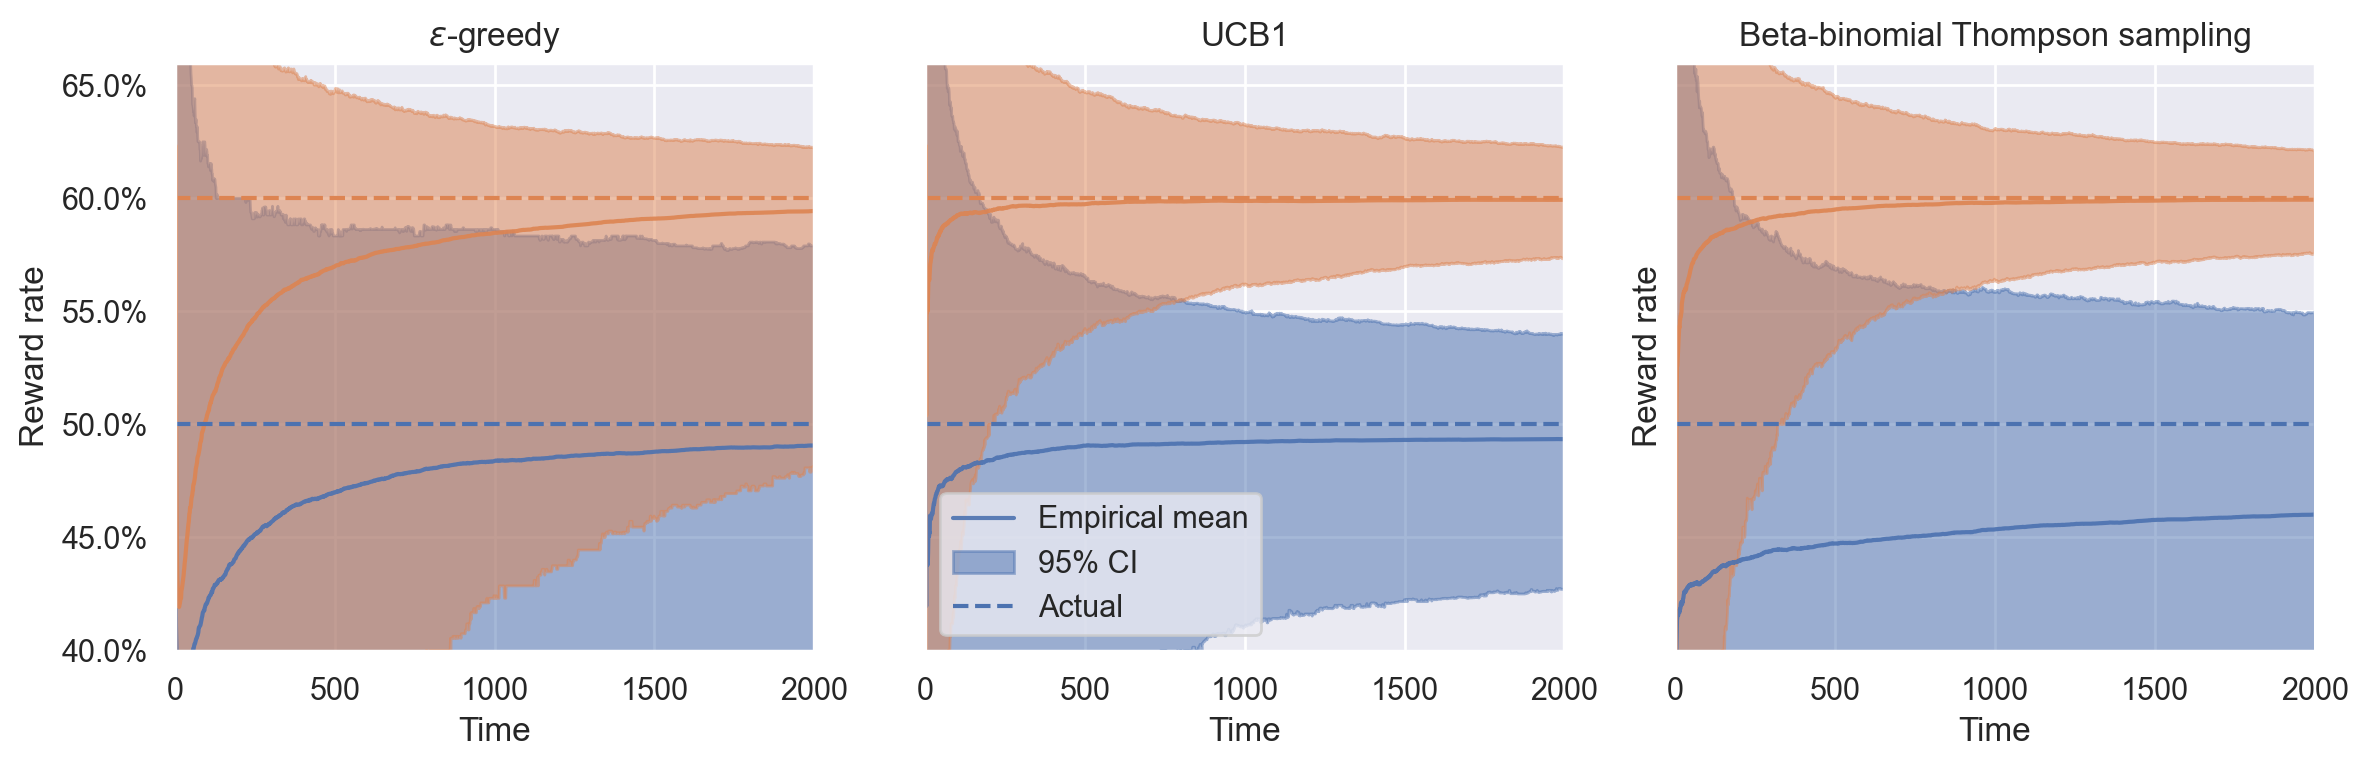

In [62]:
fig, (ε_ax, ucb1_ax, bb_ax) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))

plot_cum_arm_reward_rate(ε_greedy_reward, ax=ε_ax);
plot_cum_arm_reward_rate(ucb1_reward, ax=ucb1_ax);
plot_cum_arm_reward_rate(bb_thompson_reward, ax=bb_ax);

ε_ax.legend().set_visible(False);
ε_ax.set_title(r"$\varepsilon$-greedy");

ucb1_ax.set_ylabel(None);
ucb1_ax.set_title("UCB1");

bb_ax.set_ylim(bottom=0.8 * ARM_RATES.min())
bb_ax.legend().set_visible(False);
bb_ax.set_title("Beta-binomial Thompson sampling");

fig.tight_layout();

This plot confirms that expectation.

To wrap this post, we visualize below the (average) regret rate versus the (average) empirical reward rate of the worst arm at the end of the simulations for each policy, including A/B testing.

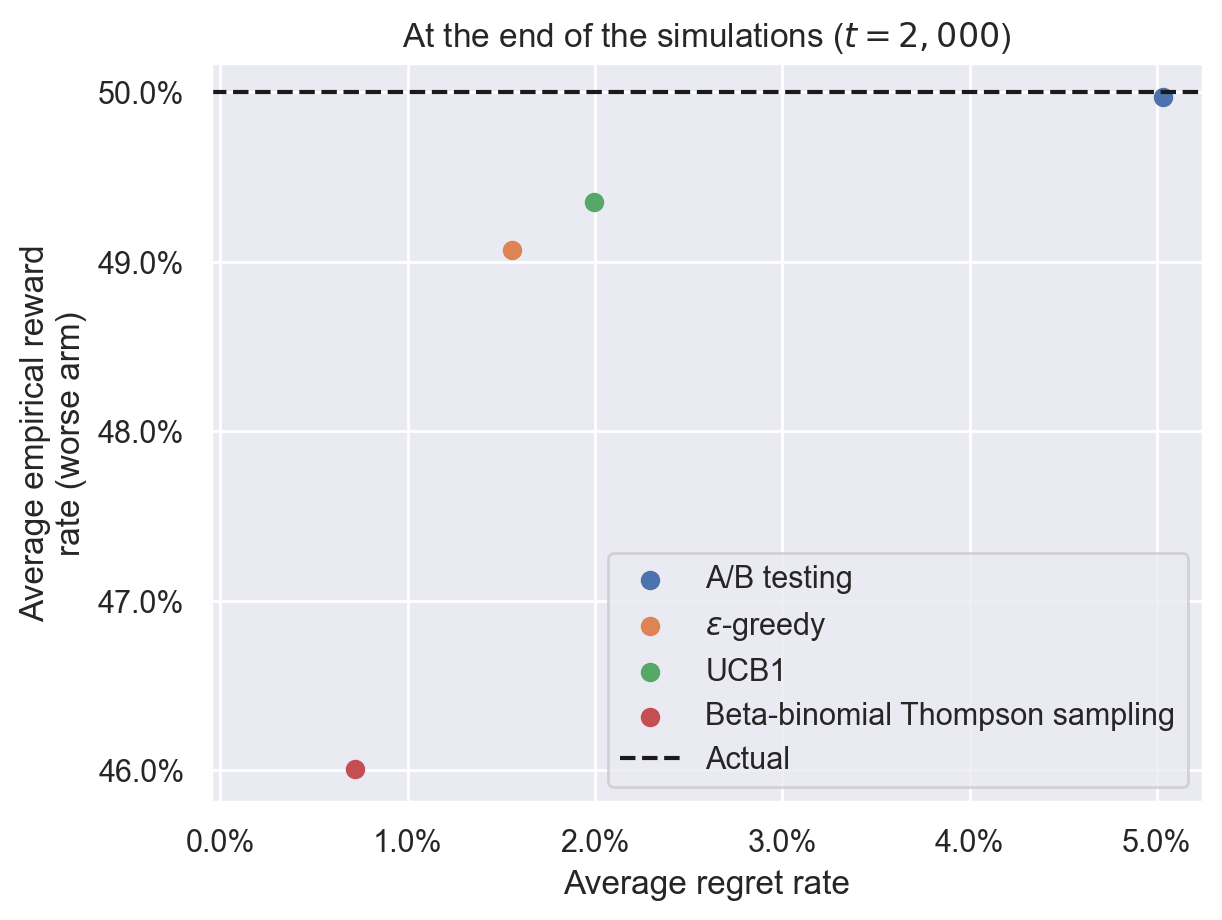

In [63]:
fig, ax = plt.subplots()

ax.scatter(
    cum_regret_rate(ab_test_reward.sum(axis=1))[:, -1].mean(),
    cum_arm_reward_rate(ab_test_reward)[:, ARM_RATES.argmin(), -1].mean(),
    label="A/B testing"
);
ax.scatter(
    cum_regret_rate(ε_greedy_reward.sum(axis=1))[:, -1].mean(),
    cum_arm_reward_rate(ε_greedy_reward)[:, ARM_RATES.argmin(), -1].mean(),
    label=r"$\varepsilon$-greedy"
);
ax.scatter(
    cum_regret_rate(ucb1_reward.sum(axis=1))[:, -1].mean(),
    cum_arm_reward_rate(ucb1_reward)[:, ARM_RATES.argmin(), -1].mean(),
    label="UCB1"
);
ax.scatter(
    cum_regret_rate(bb_thompson_reward.sum(axis=1))[:, -1].mean(),
    cum_arm_reward_rate(bb_thompson_reward)[:, ARM_RATES.argmin(), -1].mean(),
    label="Beta-binomial Thompson sampling"
);

ax.axhline(ARM_RATES.min(), c="k", ls="--", label="Actual");

make_pct_axis(ax, full=False, which="x");
ax.set_xlim(left=-0.0005);
ax.set_xlabel("Average regret rate");

make_pct_axis(ax, full=False, which="y");
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01));
ax.set_ylabel("Average empirical reward\nrate (worse arm)");

ax.set_title(f"At the end of the simulations ($t = {T:,}$)");
ax.legend();

This plot starkly illustrates the tradeoff between regret rate and bias.  The more aggressive policies that have lowest average regret rate have a much higher bias in the empirical reward rate for the worse arm.  As in many other areas of mathematics and statistics, there is [no free lunch](https://en.wikipedia.org/wiki/No_free_lunch_theorem) when trying to minimze regret while still producing good estimators of arm reward rates.

In the next post in this series, we will examine some approaches to using tools from [causal inference](https://en.wikipedia.org/wiki/Causal_inference) to reduce this bias and the tradeoffs involved with these approaches.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/31de10b81248334ddd0cdbec5bd8d34d).

In [64]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Wed Feb 12 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

matplotlib  : 3.9.2
seaborn     : 0.13.2
numpy       : 1.26.4
decorator   : 5.1.1
fastprogress: 1.0.3

